# Neural Net Modeling
In continuing with modeling, I want to see if I can better my scores and skipped song finds using Neural Networks. I will use the Keras library with the pre-processing tokenizer.



#### Table of Contents
<br>`Pre-Processing`</br>

- [Baseline](#base)
- [Tokenizer](#token)

<br>`Modeling`</br>

- [MultinomialNB](#Mnb)
- [BernoulliNB](#Bnb)
- [Logistic Regression](#Lg)
- [Ada Boost](#ada)
- [Random Forest](#forest)

<br>`Conclusion`</br>

- [Feat Importance of Best Model](#feat)
- [Notebook Conclusion](#conc)    

### Libraries

In [59]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text # to add more stopwords

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.metrics import TruePositives, TrueNegatives, FalsePositives, FalseNegatives, Precision, Recall, AUC, Accuracy
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
df = pd.read_csv('./data/lyrics_cleaned.csv')

### Baseline<a id='base'></a>  
Continuing with using confusion matrix and f1 score to have close in-depth look at how the neural network is scoring with my imbalanced data.

In [3]:
neg, pos = np.bincount(df['skip'])
total = neg + pos
print(f"Total: {total}\n    Skipped(1) count is: {pos} ({100 * pos / total:.2f}% of total)\n   Not Skipped(0) count is: {neg} ({100 * neg / total:.2f}% of total)\n")

Total: 11455
    Skipped(1) count is: 2750 (24.01% of total)
   Not Skipped(0) count is: 8705 (75.99% of total)



Again changing some words to a more vague term

In [4]:
some_words = open("./data/drop_words.txt").read().split()

for i in some_words:   
    df['lyrics'] = df['lyrics'].str.lower().str.replace(rf"\b{i}\b", 'vulgar')

### Train Test Split
Tokenizer to create a Bag of Words, then train, test, split followed by standard scaler

In [5]:
X = df['lyrics']
y = df['skip']

### Tokenizer<a id='token'></a>

In [6]:
token = Tokenizer()
token.fit_on_texts(X)
encode_X = token.texts_to_matrix(X, mode='count')

In [7]:
# since the categories are unbalanced I will stratify y
X_train, X_test, y_train, y_test = train_test_split(encode_X, y, random_state=42, stratify=y) 
# Check shapes of the split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8591, 58899), (2864, 58899), (8591,), (2864,))

In [8]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

### Re-Weighting
because my classes as so imbalanced (76%, 24%) I want to re-weigh my classes, so that the smaller class has a heavier weight 

In [9]:

weight_for_0 = (1 / neg)*(total)/2.0  # /2 helps keep the loss to similar size
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1} # mapping the weights

print(f'Weight for class 0: {weight_for_0 :.2f}')
print(f'Weight for class 1: {weight_for_1 :.2f}')

Weight for class 0: 0.66
Weight for class 1: 2.08


In [104]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      Accuracy(name='accuracy')]


In [105]:
def create_model(optimizer='adam', init_mode='uniform'):
    # create model
    model = Sequential()
    model.add(Dense(15, input_dim=X_train_sc.shape[1], kernel_initializer=init_mode, activation='relu'))
    model.add(Dense(1, kernel_initializer=init_mode, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',optimizer=optimizer,  metrics=METRICS)
    return model

In [106]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=1)

In [107]:
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 80, 100]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer, init_mode = init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

In [ ]:
grid_result = grid.fit(X_train_sc, y_train, validation_data=(X_test_sc, y_test), class_weight=class_weight)
#summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/10
573/573 [==============================] - 3s 6ms/step - loss: 0.6911 - tp: 989.0000 - fp: 2472.0000 - tn: 1894.0000 - fn: 372.0000 - precision: 0.2858 - recall: 0.7267 - auc: 0.6195 - accuracy: 0.0000e+00 - val_loss: 0.6459 - val_tp: 195.0000 - val_fp: 339.0000 - val_tn: 1837.0000 - val_fn: 493.0000 - val_precision: 0.3652 - val_recall: 0.2834 - val_auc: 0.5604 - val_accuracy: 0.0000e+00
Epoch 2/10
573/573 [==============================] - 2s 4ms/step - loss: 0.5709 - tp: 995.0000 - fp: 1332.0000 - tn: 3034.0000 - fn: 366.0000 - precision: 0.4276 - recall: 0.7311 - auc: 0.7836 - accuracy: 6.9845e-04 - val_loss: 0.7681 - val_tp: 409.0000 - val_fp: 588.0000 - val_tn: 1588.0000 - val_fn: 279.0000 - val_precision: 0.4102 - val_recall: 0.5945 - val_auc: 0.7024 - val_accuracy: 0.0000e+00
Epoch 3/10
573/573 [==============================] - 2s 4ms/step - loss: 0.2734 - tp: 1197.0000 - fp: 473.0000 - tn: 3893.0000 - fn: 164.0000 - precision: 0.7168 - recall: 0.8795 - auc: 0.9552 

287/287 [==============================] - 0s 1ms/step - loss: 1.3530 - tp: 401.0000 - fp: 487.0000 - tn: 1711.0000 - fn: 265.0000 - precision: 0.4516 - recall: 0.6021 - auc: 0.7437 - accuracy: 0.0136
Epoch 1/10
573/573 [==============================] - 3s 6ms/step - loss: 0.6944 - tp: 1374.0000 - fp: 2959.0000 - tn: 3600.0000 - fn: 659.0000 - precision: 0.3171 - recall: 0.6758 - auc: 0.6622 - accuracy: 0.0045 - val_loss: 1.1236 - val_tp: 632.0000 - val_fp: 1609.0000 - val_tn: 567.0000 - val_fn: 56.0000 - val_precision: 0.2820 - val_recall: 0.9186 - val_auc: 0.6849 - val_accuracy: 0.0017
Epoch 2/10
573/573 [==============================] - 2s 4ms/step - loss: 0.5594 - tp: 1030.0000 - fp: 1277.0000 - tn: 3084.0000 - fn: 337.0000 - precision: 0.4465 - recall: 0.7535 - auc: 0.7979 - accuracy: 5.2374e-04 - val_loss: 0.8106 - val_tp: 457.0000 - val_fp: 712.0000 - val_tn: 1464.0000 - val_fn: 231.0000 - val_precision: 0.3909 - val_recall: 0.6642 - val_auc: 0.7073 - val_accuracy: 6.9832e-04


287/287 [==============================] - 0s 1ms/step - loss: 1.1110 - tp: 476.0000 - fp: 582.0000 - tn: 1581.0000 - fn: 225.0000 - precision: 0.4499 - recall: 0.6790 - auc: 0.7261 - accuracy: 0.0199
Epoch 1/10
573/573 [==============================] - 6s 10ms/step - loss: 0.5447 - tp: 1541.0000 - fp: 1890.0000 - tn: 4604.0000 - fn: 556.0000 - precision: 0.4491 - recall: 0.7349 - auc: 0.7671 - accuracy: 0.0066 - val_loss: 0.5931 - val_tp: 533.0000 - val_fp: 616.0000 - val_tn: 1560.0000 - val_fn: 155.0000 - val_precision: 0.4639 - val_recall: 0.7747 - val_auc: 0.7969 - val_accuracy: 0.0000e+00
Epoch 2/10
573/573 [==============================] - 5s 9ms/step - loss: 0.4203 - tp: 1173.0000 - fp: 941.0000 - tn: 3390.0000 - fn: 223.0000 - precision: 0.5549 - recall: 0.8403 - auc: 0.8963 - accuracy: 3.4922e-04 - val_loss: 0.5957 - val_tp: 454.0000 - val_fp: 477.0000 - val_tn: 1699.0000 - val_fn: 234.0000 - val_precision: 0.4876 - val_recall: 0.6599 - val_auc: 0.7798 - val_accuracy: 0.0000

287/287 [==============================] - 0s 1ms/step - loss: 1.0790 - tp: 534.0000 - fp: 629.0000 - tn: 1539.0000 - fn: 161.0000 - precision: 0.4592 - recall: 0.7683 - auc: 0.7865 - accuracy: 0.0161
Epoch 1/10
573/573 [==============================] - 3s 6ms/step - loss: 0.6965 - tp: 1460.0000 - fp: 3535.0000 - tn: 2999.0000 - fn: 596.0000 - precision: 0.2923 - recall: 0.7101 - auc: 0.6654 - accuracy: 0.0054 - val_loss: 0.7745 - val_tp: 515.0000 - val_fp: 1476.0000 - val_tn: 700.0000 - val_fn: 173.0000 - val_precision: 0.2587 - val_recall: 0.7485 - val_auc: 0.5942 - val_accuracy: 0.0000e+00
Epoch 2/10
573/573 [==============================] - 3s 5ms/step - loss: 0.6549 - tp: 1114.0000 - fp: 2930.0000 - tn: 1436.0000 - fn: 247.0000 - precision: 0.2755 - recall: 0.8185 - auc: 0.6769 - accuracy: 0.0000e+00 - val_loss: 0.7731 - val_tp: 539.0000 - val_fp: 1405.0000 - val_tn: 771.0000 - val_fn: 149.0000 - val_precision: 0.2773 - val_recall: 0.7834 - val_auc: 0.6252 - val_accuracy: 0.0000

287/287 [==============================] - 0s 1ms/step - loss: 0.6717 - tp: 454.0000 - fp: 758.0000 - tn: 1440.0000 - fn: 212.0000 - precision: 0.3746 - recall: 0.6817 - auc: 0.7108 - accuracy: 0.0000e+00
Epoch 1/10
573/573 [==============================] - 3s 6ms/step - loss: 0.6863 - tp: 1612.0000 - fp: 4351.0000 - tn: 2208.0000 - fn: 421.0000 - precision: 0.2703 - recall: 0.7929 - auc: 0.6524 - accuracy: 0.0000e+00 - val_loss: 0.8027 - val_tp: 600.0000 - val_fp: 1740.0000 - val_tn: 436.0000 - val_fn: 88.0000 - val_precision: 0.2564 - val_recall: 0.8721 - val_auc: 0.6405 - val_accuracy: 0.0000e+00
Epoch 2/10
573/573 [==============================] - 3s 5ms/step - loss: 0.6565 - tp: 1240.0000 - fp: 3425.0000 - tn: 936.0000 - fn: 127.0000 - precision: 0.2658 - recall: 0.9071 - auc: 0.7078 - accuracy: 0.0000e+00 - val_loss: 0.7911 - val_tp: 597.0000 - val_fp: 1607.0000 - val_tn: 569.0000 - val_fn: 91.0000 - val_precision: 0.2709 - val_recall: 0.8677 - val_auc: 0.6555 - val_accuracy: 0

573/573 [==============================] - 3s 5ms/step - loss: 0.6962 - tp: 1154.0000 - fp: 3702.0000 - tn: 664.0000 - fn: 207.0000 - precision: 0.2376 - recall: 0.8479 - auc: 0.6031 - accuracy: 0.0000e+00 - val_loss: 0.8339 - val_tp: 589.0000 - val_fp: 1818.0000 - val_tn: 358.0000 - val_fn: 99.0000 - val_precision: 0.2447 - val_recall: 0.8561 - val_auc: 0.6163 - val_accuracy: 0.0000e+00
Epoch 10/10
287/287 [==============================] - 0s 1ms/step - loss: 0.7822 - tp: 603.0000 - fp: 1812.0000 - tn: 351.0000 - fn: 98.0000 - precision: 0.2497 - recall: 0.8602 - auc: 0.6232 - accuracy: 0.0000e+00
Epoch 1/10
573/573 [==============================] - 4s 8ms/step - loss: 0.7213 - tp: 1330.0000 - fp: 3850.0000 - tn: 2644.0000 - fn: 767.0000 - precision: 0.2568 - recall: 0.6342 - auc: 0.5523 - accuracy: 0.0000e+00 - val_loss: 0.7321 - val_tp: 338.0000 - val_fp: 1035.0000 - val_tn: 1141.0000 - val_fn: 350.0000 - val_precision: 0.2462 - val_recall: 0.4913 - val_auc: 0.5025 - val_accuracy:

573/573 [==============================] - 3s 5ms/step - loss: 0.7090 - tp: 785.0000 - fp: 2384.0000 - tn: 1977.0000 - fn: 582.0000 - precision: 0.2477 - recall: 0.5743 - auc: 0.5340 - accuracy: 0.0000e+00 - val_loss: 0.7497 - val_tp: 377.0000 - val_fp: 1197.0000 - val_tn: 979.0000 - val_fn: 311.0000 - val_precision: 0.2395 - val_recall: 0.5480 - val_auc: 0.5067 - val_accuracy: 0.0000e+00
Epoch 9/10
573/573 [==============================] - 3s 5ms/step - loss: 0.7082 - tp: 788.0000 - fp: 2387.0000 - tn: 1974.0000 - fn: 579.0000 - precision: 0.2482 - recall: 0.5764 - auc: 0.5363 - accuracy: 0.0000e+00 - val_loss: 0.7500 - val_tp: 382.0000 - val_fp: 1198.0000 - val_tn: 978.0000 - val_fn: 306.0000 - val_precision: 0.2418 - val_recall: 0.5552 - val_auc: 0.5083 - val_accuracy: 0.0000e+00
Epoch 10/10
287/287 [==============================] - 0s 1ms/step - loss: 0.7230 - tp: 413.0000 - fp: 1197.0000 - tn: 971.0000 - fn: 282.0000 - precision: 0.2565 - recall: 0.5942 - auc: 0.5454 - accuracy:

Epoch 8/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0025 - tp: 1396.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.0875 - val_loss: 1.2485 - val_tp: 429.0000 - val_fp: 407.0000 - val_tn: 1769.0000 - val_fn: 259.0000 - val_precision: 0.5132 - val_recall: 0.6235 - val_auc: 0.7909 - val_accuracy: 0.0199
Epoch 9/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0022 - tp: 1396.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.0918 - val_loss: 1.2617 - val_tp: 429.0000 - val_fp: 410.0000 - val_tn: 1766.0000 - val_fn: 259.0000 - val_precision: 0.5113 - val_recall: 0.6235 - val_auc: 0.7886 - val_accuracy: 0.0206
Epoch 10/10
287/287 [==============================] - 0s 1ms/step - loss: 0.8725 - tp: 482.0000 - fp: 510.0000 - tn: 1688.0000 - fn: 184.0000 - precision: 0.4859 - recall: 0.7237 - auc: 0.8160 - accura

Epoch 8/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0933 - tp: 1315.0000 - fp: 108.0000 - tn: 4258.0000 - fn: 46.0000 - precision: 0.9241 - recall: 0.9662 - auc: 0.9971 - accuracy: 0.0021 - val_loss: 1.1632 - val_tp: 517.0000 - val_fp: 631.0000 - val_tn: 1545.0000 - val_fn: 171.0000 - val_precision: 0.4503 - val_recall: 0.7515 - val_auc: 0.7857 - val_accuracy: 0.0066
Epoch 9/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0625 - tp: 1333.0000 - fp: 53.0000 - tn: 4313.0000 - fn: 28.0000 - precision: 0.9618 - recall: 0.9794 - auc: 0.9990 - accuracy: 0.0028 - val_loss: 1.2699 - val_tp: 530.0000 - val_fp: 674.0000 - val_tn: 1502.0000 - val_fn: 158.0000 - val_precision: 0.4402 - val_recall: 0.7703 - val_auc: 0.7814 - val_accuracy: 0.0073
Epoch 10/10
287/287 [==============================] - 0s 1ms/step - loss: 1.4652 - tp: 609.0000 - fp: 803.0000 - tn: 1360.0000 - fn: 92.0000 - precision: 0.4313 - recall: 0.8688 - auc: 0.8057 - accuracy: 0.0115
E

Epoch 8/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0773 - tp: 1321.0000 - fp: 72.0000 - tn: 4289.0000 - fn: 46.0000 - precision: 0.9483 - recall: 0.9663 - auc: 0.9979 - accuracy: 0.0040 - val_loss: 1.6542 - val_tp: 515.0000 - val_fp: 695.0000 - val_tn: 1481.0000 - val_fn: 173.0000 - val_precision: 0.4256 - val_recall: 0.7485 - val_auc: 0.7738 - val_accuracy: 0.0216
Epoch 9/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0545 - tp: 1334.0000 - fp: 36.0000 - tn: 4325.0000 - fn: 33.0000 - precision: 0.9737 - recall: 0.9759 - auc: 0.9991 - accuracy: 0.0052 - val_loss: 1.7918 - val_tp: 530.0000 - val_fp: 732.0000 - val_tn: 1444.0000 - val_fn: 158.0000 - val_precision: 0.4200 - val_recall: 0.7703 - val_auc: 0.7689 - val_accuracy: 0.0262
Epoch 10/10
287/287 [==============================] - 0s 1ms/step - loss: 2.5738 - tp: 593.0000 - fp: 860.0000 - tn: 1308.0000 - fn: 102.0000 - precision: 0.4081 - recall: 0.8532 - auc: 0.7913 - accuracy: 0.0492
E

Epoch 8/10
573/573 [==============================] - 7s 13ms/step - loss: 0.0012 - tp: 1395.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 1.0000 - precision: 1.0000 - recall: 0.9993 - auc: 1.0000 - accuracy: 0.0840 - val_loss: 1.3410 - val_tp: 440.0000 - val_fp: 442.0000 - val_tn: 1734.0000 - val_fn: 248.0000 - val_precision: 0.4989 - val_recall: 0.6395 - val_auc: 0.7851 - val_accuracy: 0.0192
Epoch 9/10
573/573 [==============================] - 7s 13ms/step - loss: 0.0011 - tp: 1395.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 1.0000 - precision: 1.0000 - recall: 0.9993 - auc: 1.0000 - accuracy: 0.0877 - val_loss: 1.3829 - val_tp: 437.0000 - val_fp: 431.0000 - val_tn: 1745.0000 - val_fn: 251.0000 - val_precision: 0.5035 - val_recall: 0.6352 - val_auc: 0.7847 - val_accuracy: 0.0216
Epoch 10/10
287/287 [==============================] - 0s 1ms/step - loss: 1.1146 - tp: 552.0000 - fp: 667.0000 - tn: 1531.0000 - fn: 114.0000 - precision: 0.4528 - recall: 0.8288 - auc: 0.8247 - accuracy: 0.

Epoch 8/10
573/573 [==============================] - 2s 4ms/step - loss: 0.0113 - tp: 1346.0000 - fp: 4.0000 - tn: 4362.0000 - fn: 15.0000 - precision: 0.9970 - recall: 0.9890 - auc: 0.9999 - accuracy: 0.0737 - val_loss: 0.8672 - val_tp: 479.0000 - val_fp: 402.0000 - val_tn: 1774.0000 - val_fn: 209.0000 - val_precision: 0.5437 - val_recall: 0.6962 - val_auc: 0.8357 - val_accuracy: 0.0066
Epoch 9/10
573/573 [==============================] - 2s 4ms/step - loss: 0.0105 - tp: 1347.0000 - fp: 3.0000 - tn: 4363.0000 - fn: 14.0000 - precision: 0.9978 - recall: 0.9897 - auc: 0.9999 - accuracy: 0.0770 - val_loss: 0.8821 - val_tp: 479.0000 - val_fp: 403.0000 - val_tn: 1773.0000 - val_fn: 209.0000 - val_precision: 0.5431 - val_recall: 0.6962 - val_auc: 0.8361 - val_accuracy: 0.0073
Epoch 10/10
287/287 [==============================] - 0s 1ms/step - loss: 0.5126 - tp: 516.0000 - fp: 363.0000 - tn: 1800.0000 - fn: 185.0000 - precision: 0.5870 - recall: 0.7361 - auc: 0.8736 - accuracy: 0.0035
Epo

Epoch 8/10
573/573 [==============================] - 2s 4ms/step - loss: 0.0154 - tp: 1359.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 8.0000 - precision: 1.0000 - recall: 0.9941 - auc: 0.9999 - accuracy: 0.0681 - val_loss: 0.9236 - val_tp: 486.0000 - val_fp: 451.0000 - val_tn: 1725.0000 - val_fn: 202.0000 - val_precision: 0.5187 - val_recall: 0.7064 - val_auc: 0.8235 - val_accuracy: 0.0073
Epoch 9/10
573/573 [==============================] - 2s 4ms/step - loss: 0.0149 - tp: 1359.0000 - fp: 1.0000 - tn: 4360.0000 - fn: 8.0000 - precision: 0.9993 - recall: 0.9941 - auc: 0.9999 - accuracy: 0.0725 - val_loss: 0.9392 - val_tp: 484.0000 - val_fp: 448.0000 - val_tn: 1728.0000 - val_fn: 204.0000 - val_precision: 0.5193 - val_recall: 0.7035 - val_auc: 0.8226 - val_accuracy: 0.0077
Epoch 10/10
287/287 [==============================] - 0s 1ms/step - loss: 0.5417 - tp: 499.0000 - fp: 378.0000 - tn: 1790.0000 - fn: 196.0000 - precision: 0.5690 - recall: 0.7180 - auc: 0.8544 - accuracy: 0.0014
E

Epoch 8/10
573/573 [==============================] - 5s 9ms/step - loss: 0.1534 - tp: 1322.0000 - fp: 267.0000 - tn: 4064.0000 - fn: 74.0000 - precision: 0.8320 - recall: 0.9470 - auc: 0.9868 - accuracy: 0.1118 - val_loss: 1.6839 - val_tp: 474.0000 - val_fp: 576.0000 - val_tn: 1600.0000 - val_fn: 214.0000 - val_precision: 0.4514 - val_recall: 0.6890 - val_auc: 0.7536 - val_accuracy: 0.0482
Epoch 9/10
573/573 [==============================] - 5s 9ms/step - loss: 0.1349 - tp: 1331.0000 - fp: 268.0000 - tn: 4063.0000 - fn: 65.0000 - precision: 0.8324 - recall: 0.9534 - auc: 0.9882 - accuracy: 0.1196 - val_loss: 1.6844 - val_tp: 419.0000 - val_fp: 473.0000 - val_tn: 1703.0000 - val_fn: 269.0000 - val_precision: 0.4697 - val_recall: 0.6090 - val_auc: 0.7141 - val_accuracy: 0.0349
Epoch 10/10
287/287 [==============================] - 0s 1ms/step - loss: 1.9519 - tp: 533.0000 - fp: 697.0000 - tn: 1501.0000 - fn: 133.0000 - precision: 0.4333 - recall: 0.8003 - auc: 0.7937 - accuracy: 0.0541

Epoch 8/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0985 - tp: 1336.0000 - fp: 25.0000 - tn: 4341.0000 - fn: 25.0000 - precision: 0.9816 - recall: 0.9816 - auc: 0.9986 - accuracy: 3.4922e-04 - val_loss: 0.5736 - val_tp: 534.0000 - val_fp: 536.0000 - val_tn: 1640.0000 - val_fn: 154.0000 - val_precision: 0.4991 - val_recall: 0.7762 - val_auc: 0.8336 - val_accuracy: 3.4916e-04
Epoch 9/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0899 - tp: 1338.0000 - fp: 14.0000 - tn: 4352.0000 - fn: 23.0000 - precision: 0.9896 - recall: 0.9831 - auc: 0.9989 - accuracy: 3.4922e-04 - val_loss: 0.5745 - val_tp: 537.0000 - val_fp: 534.0000 - val_tn: 1642.0000 - val_fn: 151.0000 - val_precision: 0.5014 - val_recall: 0.7805 - val_auc: 0.8335 - val_accuracy: 3.4916e-04
Epoch 10/10
287/287 [==============================] - 0s 1ms/step - loss: 0.5055 - tp: 614.0000 - fp: 644.0000 - tn: 1519.0000 - fn: 87.0000 - precision: 0.4881 - recall: 0.8759 - auc: 0.8632 - acc

573/573 [==============================] - 3s 5ms/step - loss: 0.0949 - tp: 1337.0000 - fp: 16.0000 - tn: 4345.0000 - fn: 30.0000 - precision: 0.9882 - recall: 0.9781 - auc: 0.9994 - accuracy: 1.7458e-04 - val_loss: 0.5153 - val_tp: 511.0000 - val_fp: 472.0000 - val_tn: 1704.0000 - val_fn: 177.0000 - val_precision: 0.5198 - val_recall: 0.7427 - val_auc: 0.8344 - val_accuracy: 3.4916e-04
Epoch 8/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0839 - tp: 1337.0000 - fp: 9.0000 - tn: 4352.0000 - fn: 30.0000 - precision: 0.9933 - recall: 0.9781 - auc: 0.9996 - accuracy: 1.7458e-04 - val_loss: 0.5158 - val_tp: 511.0000 - val_fp: 467.0000 - val_tn: 1709.0000 - val_fn: 177.0000 - val_precision: 0.5225 - val_recall: 0.7427 - val_auc: 0.8346 - val_accuracy: 3.4916e-04
Epoch 9/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0751 - tp: 1345.0000 - fp: 6.0000 - tn: 4355.0000 - fn: 22.0000 - precision: 0.9956 - recall: 0.9839 - auc: 0.9997 - accuracy: 1.7458e

573/573 [==============================] - 3s 5ms/step - loss: 1.1008 - tp: 298.0000 - fp: 2159.0000 - tn: 2172.0000 - fn: 1098.0000 - precision: 0.1213 - recall: 0.2135 - auc: 0.3147 - accuracy: 0.0000e+00 - val_loss: 0.9052 - val_tp: 132.0000 - val_fp: 1094.0000 - val_tn: 1082.0000 - val_fn: 556.0000 - val_precision: 0.1077 - val_recall: 0.1919 - val_auc: 0.3070 - val_accuracy: 0.0000e+00
Epoch 7/10
573/573 [==============================] - 3s 5ms/step - loss: 1.1490 - tp: 326.0000 - fp: 2322.0000 - tn: 2009.0000 - fn: 1070.0000 - precision: 0.1231 - recall: 0.2335 - auc: 0.3185 - accuracy: 0.0000e+00 - val_loss: 0.9423 - val_tp: 151.0000 - val_fp: 1157.0000 - val_tn: 1019.0000 - val_fn: 537.0000 - val_precision: 0.1154 - val_recall: 0.2195 - val_auc: 0.3069 - val_accuracy: 0.0000e+00
Epoch 8/10
573/573 [==============================] - 3s 5ms/step - loss: 1.1899 - tp: 364.0000 - fp: 2475.0000 - tn: 1856.0000 - fn: 1032.0000 - precision: 0.1282 - recall: 0.2607 - auc: 0.3226 - accu

573/573 [==============================] - 3s 5ms/step - loss: 0.0231 - tp: 1356.0000 - fp: 111.0000 - tn: 4255.0000 - fn: 5.0000 - precision: 0.9243 - recall: 0.9963 - auc: 0.9996 - accuracy: 0.1065 - val_loss: 1.7281 - val_tp: 427.0000 - val_fp: 393.0000 - val_tn: 1783.0000 - val_fn: 261.0000 - val_precision: 0.5207 - val_recall: 0.6206 - val_auc: 0.7592 - val_accuracy: 0.0346
Epoch 6/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0184 - tp: 1360.0000 - fp: 104.0000 - tn: 4262.0000 - fn: 1.0000 - precision: 0.9290 - recall: 0.9993 - auc: 0.9995 - accuracy: 0.1074 - val_loss: 1.7740 - val_tp: 432.0000 - val_fp: 401.0000 - val_tn: 1775.0000 - val_fn: 256.0000 - val_precision: 0.5186 - val_recall: 0.6279 - val_auc: 0.7547 - val_accuracy: 0.0346
Epoch 7/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0138 - tp: 1361.0000 - fp: 98.0000 - tn: 4268.0000 - fn: 0.0000e+00 - precision: 0.9328 - recall: 1.0000 - auc: 0.9999 - accuracy: 0.1077 - val_loss:

Epoch 5/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0107 - tp: 1367.0000 - fp: 61.0000 - tn: 4300.0000 - fn: 0.0000e+00 - precision: 0.9573 - recall: 1.0000 - auc: 0.9998 - accuracy: 0.0325 - val_loss: 0.8965 - val_tp: 387.0000 - val_fp: 413.0000 - val_tn: 1763.0000 - val_fn: 301.0000 - val_precision: 0.4837 - val_recall: 0.5625 - val_auc: 0.7771 - val_accuracy: 0.0031
Epoch 6/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0093 - tp: 1367.0000 - fp: 59.0000 - tn: 4302.0000 - fn: 0.0000e+00 - precision: 0.9586 - recall: 1.0000 - auc: 0.9998 - accuracy: 0.0372 - val_loss: 0.9323 - val_tp: 379.0000 - val_fp: 403.0000 - val_tn: 1773.0000 - val_fn: 309.0000 - val_precision: 0.4847 - val_recall: 0.5509 - val_auc: 0.7751 - val_accuracy: 0.0031
Epoch 7/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0090 - tp: 1366.0000 - fp: 57.0000 - tn: 4304.0000 - fn: 1.0000 - precision: 0.9599 - recall: 0.9993 - auc: 1.0000 - accuracy: 0.040

Epoch 5/10
573/573 [==============================] - 3s 5ms/step - loss: 8.4890 - tp: 1184.0000 - fp: 133.0000 - tn: 4198.0000 - fn: 212.0000 - precision: 0.8990 - recall: 0.8481 - auc: 0.8948 - accuracy: 0.1572 - val_loss: 30.4267 - val_tp: 270.0000 - val_fp: 311.0000 - val_tn: 1865.0000 - val_fn: 418.0000 - val_precision: 0.4647 - val_recall: 0.3924 - val_auc: 0.5365 - val_accuracy: 0.1023
Epoch 6/10
573/573 [==============================] - 3s 5ms/step - loss: 5.2850 - tp: 1257.0000 - fp: 130.0000 - tn: 4201.0000 - fn: 139.0000 - precision: 0.9063 - recall: 0.9004 - auc: 0.9318 - accuracy: 0.1928 - val_loss: 30.4097 - val_tp: 287.0000 - val_fp: 371.0000 - val_tn: 1805.0000 - val_fn: 401.0000 - val_precision: 0.4362 - val_recall: 0.4172 - val_auc: 0.5422 - val_accuracy: 0.1041
Epoch 7/10
573/573 [==============================] - 3s 5ms/step - loss: 3.3351 - tp: 1299.0000 - fp: 141.0000 - tn: 4190.0000 - fn: 97.0000 - precision: 0.9021 - recall: 0.9305 - auc: 0.9499 - accuracy: 0.2

Epoch 5/10
573/573 [==============================] - 7s 13ms/step - loss: 0.0090 - tp: 1352.0000 - fp: 3.0000 - tn: 4363.0000 - fn: 9.0000 - precision: 0.9978 - recall: 0.9934 - auc: 1.0000 - accuracy: 0.0719 - val_loss: 1.1620 - val_tp: 422.0000 - val_fp: 342.0000 - val_tn: 1834.0000 - val_fn: 266.0000 - val_precision: 0.5524 - val_recall: 0.6134 - val_auc: 0.7815 - val_accuracy: 0.0209
Epoch 6/10
573/573 [==============================] - 7s 13ms/step - loss: 0.0083 - tp: 1352.0000 - fp: 5.0000 - tn: 4361.0000 - fn: 9.0000 - precision: 0.9963 - recall: 0.9934 - auc: 0.9997 - accuracy: 0.0732 - val_loss: 1.1834 - val_tp: 418.0000 - val_fp: 355.0000 - val_tn: 1821.0000 - val_fn: 270.0000 - val_precision: 0.5408 - val_recall: 0.6076 - val_auc: 0.7776 - val_accuracy: 0.0213
Epoch 7/10
573/573 [==============================] - 7s 13ms/step - loss: 0.0067 - tp: 1354.0000 - fp: 3.0000 - tn: 4363.0000 - fn: 7.0000 - precision: 0.9978 - recall: 0.9949 - auc: 1.0000 - accuracy: 0.0725 - val_

Epoch 5/10
573/573 [==============================] - 7s 12ms/step - loss: 0.0043 - tp: 1367.0000 - fp: 10.0000 - tn: 4351.0000 - fn: 0.0000e+00 - precision: 0.9927 - recall: 1.0000 - auc: 0.9999 - accuracy: 0.0279 - val_loss: 0.9336 - val_tp: 339.0000 - val_fp: 327.0000 - val_tn: 1849.0000 - val_fn: 349.0000 - val_precision: 0.5090 - val_recall: 0.4927 - val_auc: 0.7657 - val_accuracy: 0.0014
Epoch 6/10
573/573 [==============================] - 7s 12ms/step - loss: 0.0034 - tp: 1365.0000 - fp: 7.0000 - tn: 4354.0000 - fn: 2.0000 - precision: 0.9949 - recall: 0.9985 - auc: 0.9999 - accuracy: 0.0297 - val_loss: 0.9745 - val_tp: 337.0000 - val_fp: 336.0000 - val_tn: 1840.0000 - val_fn: 351.0000 - val_precision: 0.5007 - val_recall: 0.4898 - val_auc: 0.7595 - val_accuracy: 0.0014
Epoch 7/10
573/573 [==============================] - 7s 12ms/step - loss: 0.0027 - tp: 1367.0000 - fp: 6.0000 - tn: 4355.0000 - fn: 0.0000e+00 - precision: 0.9956 - recall: 1.0000 - auc: 0.9999 - accuracy: 0.03

Epoch 5/10
573/573 [==============================] - 2s 4ms/step - loss: 0.1471 - tp: 1324.0000 - fp: 245.0000 - tn: 4086.0000 - fn: 72.0000 - precision: 0.8438 - recall: 0.9484 - auc: 0.9873 - accuracy: 0.0162 - val_loss: 1.6550 - val_tp: 334.0000 - val_fp: 451.0000 - val_tn: 1725.0000 - val_fn: 354.0000 - val_precision: 0.4255 - val_recall: 0.4855 - val_auc: 0.6619 - val_accuracy: 0.0087
Epoch 6/10
573/573 [==============================] - 2s 4ms/step - loss: 0.0674 - tp: 1367.0000 - fp: 115.0000 - tn: 4216.0000 - fn: 29.0000 - precision: 0.9224 - recall: 0.9792 - auc: 0.9978 - accuracy: 0.0250 - val_loss: 2.0886 - val_tp: 340.0000 - val_fp: 456.0000 - val_tn: 1720.0000 - val_fn: 348.0000 - val_precision: 0.4271 - val_recall: 0.4942 - val_auc: 0.6695 - val_accuracy: 0.0161
Epoch 7/10
573/573 [==============================] - 2s 4ms/step - loss: 0.0381 - tp: 1377.0000 - fp: 56.0000 - tn: 4275.0000 - fn: 19.0000 - precision: 0.9609 - recall: 0.9864 - auc: 0.9994 - accuracy: 0.0367 -

Epoch 5/10
573/573 [==============================] - 5s 9ms/step - loss: 0.2832 - tp: 1196.0000 - fp: 290.0000 - tn: 4076.0000 - fn: 165.0000 - precision: 0.8048 - recall: 0.8788 - auc: 0.9548 - accuracy: 0.0147 - val_loss: 0.9370 - val_tp: 369.0000 - val_fp: 436.0000 - val_tn: 1740.0000 - val_fn: 319.0000 - val_precision: 0.4584 - val_recall: 0.5363 - val_auc: 0.6779 - val_accuracy: 0.0042
Epoch 6/10
573/573 [==============================] - 5s 9ms/step - loss: 0.2835 - tp: 1204.0000 - fp: 227.0000 - tn: 4139.0000 - fn: 157.0000 - precision: 0.8414 - recall: 0.8846 - auc: 0.9599 - accuracy: 0.0211 - val_loss: 0.9104 - val_tp: 391.0000 - val_fp: 459.0000 - val_tn: 1717.0000 - val_fn: 297.0000 - val_precision: 0.4600 - val_recall: 0.5683 - val_auc: 0.6788 - val_accuracy: 0.0038
Epoch 7/10
573/573 [==============================] - 5s 9ms/step - loss: 0.2242 - tp: 1236.0000 - fp: 175.0000 - tn: 4191.0000 - fn: 125.0000 - precision: 0.8760 - recall: 0.9082 - auc: 0.9722 - accuracy: 0.02

Epoch 5/10
573/573 [==============================] - 5s 9ms/step - loss: 0.2944 - tp: 1209.0000 - fp: 230.0000 - tn: 4131.0000 - fn: 158.0000 - precision: 0.8402 - recall: 0.8844 - auc: 0.9536 - accuracy: 0.0180 - val_loss: 0.9332 - val_tp: 394.0000 - val_fp: 442.0000 - val_tn: 1734.0000 - val_fn: 294.0000 - val_precision: 0.4713 - val_recall: 0.5727 - val_auc: 0.6946 - val_accuracy: 0.0017
Epoch 6/10
573/573 [==============================] - 5s 9ms/step - loss: 0.2479 - tp: 1224.0000 - fp: 192.0000 - tn: 4169.0000 - fn: 143.0000 - precision: 0.8644 - recall: 0.8954 - auc: 0.9659 - accuracy: 0.0168 - val_loss: 1.0188 - val_tp: 405.0000 - val_fp: 449.0000 - val_tn: 1727.0000 - val_fn: 283.0000 - val_precision: 0.4742 - val_recall: 0.5887 - val_auc: 0.7162 - val_accuracy: 0.0049
Epoch 7/10
573/573 [==============================] - 5s 9ms/step - loss: 0.2349 - tp: 1235.0000 - fp: 154.0000 - tn: 4207.0000 - fn: 132.0000 - precision: 0.8891 - recall: 0.9034 - auc: 0.9683 - accuracy: 0.02

573/573 [==============================] - 3s 5ms/step - loss: 0.6375 - tp: 1046.0000 - fp: 2058.0000 - tn: 2273.0000 - fn: 350.0000 - precision: 0.3370 - recall: 0.7493 - auc: 0.7103 - accuracy: 0.0000e+00 - val_loss: 0.8256 - val_tp: 458.0000 - val_fp: 1111.0000 - val_tn: 1065.0000 - val_fn: 230.0000 - val_precision: 0.2919 - val_recall: 0.6657 - val_auc: 0.6145 - val_accuracy: 0.0000e+00
Epoch 5/10
573/573 [==============================] - 3s 5ms/step - loss: 0.6145 - tp: 1082.0000 - fp: 1935.0000 - tn: 2396.0000 - fn: 314.0000 - precision: 0.3586 - recall: 0.7751 - auc: 0.7440 - accuracy: 0.0000e+00 - val_loss: 0.8159 - val_tp: 461.0000 - val_fp: 1066.0000 - val_tn: 1110.0000 - val_fn: 227.0000 - val_precision: 0.3019 - val_recall: 0.6701 - val_auc: 0.6226 - val_accuracy: 0.0000e+00
Epoch 6/10
573/573 [==============================] - 3s 5ms/step - loss: 0.5945 - tp: 1100.0000 - fp: 1803.0000 - tn: 2528.0000 - fn: 296.0000 - precision: 0.3789 - recall: 0.7880 - auc: 0.7713 - accu

573/573 [==============================] - 3s 5ms/step - loss: 0.8252 - tp: 697.0000 - fp: 2393.0000 - tn: 1973.0000 - fn: 664.0000 - precision: 0.2256 - recall: 0.5121 - auc: 0.4908 - accuracy: 0.0000e+00 - val_loss: 0.9124 - val_tp: 358.0000 - val_fp: 1213.0000 - val_tn: 963.0000 - val_fn: 330.0000 - val_precision: 0.2279 - val_recall: 0.5203 - val_auc: 0.5001 - val_accuracy: 3.4916e-04
Epoch 4/10
573/573 [==============================] - 3s 5ms/step - loss: 0.8239 - tp: 698.0000 - fp: 2396.0000 - tn: 1970.0000 - fn: 663.0000 - precision: 0.2256 - recall: 0.5129 - auc: 0.4920 - accuracy: 0.0000e+00 - val_loss: 0.9124 - val_tp: 359.0000 - val_fp: 1212.0000 - val_tn: 964.0000 - val_fn: 329.0000 - val_precision: 0.2285 - val_recall: 0.5218 - val_auc: 0.5010 - val_accuracy: 3.4916e-04
Epoch 5/10
573/573 [==============================] - 3s 5ms/step - loss: 0.8226 - tp: 700.0000 - fp: 2404.0000 - tn: 1962.0000 - fn: 661.0000 - precision: 0.2255 - recall: 0.5143 - auc: 0.4930 - accuracy:

573/573 [==============================] - 3s 5ms/step - loss: 1.1570 - tp: 271.0000 - fp: 985.0000 - tn: 3376.0000 - fn: 1096.0000 - precision: 0.2158 - recall: 0.1982 - auc: 0.3938 - accuracy: 0.0000e+00 - val_loss: 0.9522 - val_tp: 154.0000 - val_fp: 500.0000 - val_tn: 1676.0000 - val_fn: 534.0000 - val_precision: 0.2355 - val_recall: 0.2238 - val_auc: 0.4119 - val_accuracy: 3.4916e-04
Epoch 3/10
573/573 [==============================] - 3s 5ms/step - loss: 1.1538 - tp: 277.0000 - fp: 1008.0000 - tn: 3353.0000 - fn: 1090.0000 - precision: 0.2156 - recall: 0.2026 - auc: 0.3940 - accuracy: 0.0000e+00 - val_loss: 0.9534 - val_tp: 159.0000 - val_fp: 517.0000 - val_tn: 1659.0000 - val_fn: 529.0000 - val_precision: 0.2352 - val_recall: 0.2311 - val_auc: 0.4116 - val_accuracy: 3.4916e-04
Epoch 4/10
573/573 [==============================] - 3s 5ms/step - loss: 1.1505 - tp: 280.0000 - fp: 1026.0000 - tn: 3335.0000 - fn: 1087.0000 - precision: 0.2144 - recall: 0.2048 - auc: 0.3943 - accurac

Epoch 2/10
573/573 [==============================] - 3s 5ms/step - loss: 0.1212 - tp: 1338.0000 - fp: 173.0000 - tn: 4158.0000 - fn: 58.0000 - precision: 0.8855 - recall: 0.9585 - auc: 0.9926 - accuracy: 0.0087 - val_loss: 0.7830 - val_tp: 420.0000 - val_fp: 395.0000 - val_tn: 1781.0000 - val_fn: 268.0000 - val_precision: 0.5153 - val_recall: 0.6105 - val_auc: 0.7832 - val_accuracy: 0.0045
Epoch 3/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0179 - tp: 1389.0000 - fp: 20.0000 - tn: 4311.0000 - fn: 7.0000 - precision: 0.9858 - recall: 0.9950 - auc: 0.9999 - accuracy: 0.0258 - val_loss: 0.9446 - val_tp: 417.0000 - val_fp: 398.0000 - val_tn: 1778.0000 - val_fn: 271.0000 - val_precision: 0.5117 - val_recall: 0.6061 - val_auc: 0.7777 - val_accuracy: 0.0070
Epoch 4/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0057 - tp: 1395.0000 - fp: 4.0000 - tn: 4327.0000 - fn: 1.0000 - precision: 0.9971 - recall: 0.9993 - auc: 1.0000 - accuracy: 0.0354 - val

Epoch 2/10
573/573 [==============================] - 3s 5ms/step - loss: 0.7410 - tp: 827.0000 - fp: 1002.0000 - tn: 3364.0000 - fn: 534.0000 - precision: 0.4522 - recall: 0.6076 - auc: 0.7288 - accuracy: 0.0012 - val_loss: 0.6473 - val_tp: 314.0000 - val_fp: 352.0000 - val_tn: 1824.0000 - val_fn: 374.0000 - val_precision: 0.4715 - val_recall: 0.4564 - val_auc: 0.6898 - val_accuracy: 0.0000e+00
Epoch 3/10
573/573 [==============================] - 3s 5ms/step - loss: 0.5984 - tp: 820.0000 - fp: 766.0000 - tn: 3600.0000 - fn: 541.0000 - precision: 0.5170 - recall: 0.6025 - auc: 0.7810 - accuracy: 5.2383e-04 - val_loss: 0.6218 - val_tp: 340.0000 - val_fp: 374.0000 - val_tn: 1802.0000 - val_fn: 348.0000 - val_precision: 0.4762 - val_recall: 0.4942 - val_auc: 0.7052 - val_accuracy: 0.0000e+00
Epoch 4/10
573/573 [==============================] - 3s 5ms/step - loss: 0.5037 - tp: 930.0000 - fp: 754.0000 - tn: 3612.0000 - fn: 431.0000 - precision: 0.5523 - recall: 0.6833 - auc: 0.8463 - accu

Epoch 2/10
573/573 [==============================] - 3s 5ms/step - loss: 0.5822 - tp: 869.0000 - fp: 898.0000 - tn: 3463.0000 - fn: 498.0000 - precision: 0.4918 - recall: 0.6357 - auc: 0.7915 - accuracy: 0.0000e+00 - val_loss: 0.5321 - val_tp: 372.0000 - val_fp: 400.0000 - val_tn: 1776.0000 - val_fn: 316.0000 - val_precision: 0.4819 - val_recall: 0.5407 - val_auc: 0.7595 - val_accuracy: 0.0000e+00
Epoch 3/10
573/573 [==============================] - 3s 5ms/step - loss: 0.5177 - tp: 970.0000 - fp: 836.0000 - tn: 3525.0000 - fn: 397.0000 - precision: 0.5371 - recall: 0.7096 - auc: 0.8361 - accuracy: 0.0000e+00 - val_loss: 0.5128 - val_tp: 355.0000 - val_fp: 357.0000 - val_tn: 1819.0000 - val_fn: 333.0000 - val_precision: 0.4986 - val_recall: 0.5160 - val_auc: 0.7648 - val_accuracy: 0.0000e+00
Epoch 4/10
573/573 [==============================] - 3s 5ms/step - loss: 0.4506 - tp: 1048.0000 - fp: 743.0000 - tn: 3618.0000 - fn: 319.0000 - precision: 0.5851 - recall: 0.7666 - auc: 0.8779 - 

Epoch 2/10
573/573 [==============================] - 7s 12ms/step - loss: 0.2310 - tp: 1226.0000 - fp: 276.0000 - tn: 4055.0000 - fn: 170.0000 - precision: 0.8162 - recall: 0.8782 - auc: 0.9686 - accuracy: 0.0124 - val_loss: 0.7402 - val_tp: 458.0000 - val_fp: 481.0000 - val_tn: 1695.0000 - val_fn: 230.0000 - val_precision: 0.4878 - val_recall: 0.6657 - val_auc: 0.7835 - val_accuracy: 0.0031
Epoch 3/10
573/573 [==============================] - 7s 12ms/step - loss: 0.0800 - tp: 1334.0000 - fp: 59.0000 - tn: 4272.0000 - fn: 62.0000 - precision: 0.9576 - recall: 0.9556 - auc: 0.9970 - accuracy: 0.0360 - val_loss: 0.9284 - val_tp: 486.0000 - val_fp: 520.0000 - val_tn: 1656.0000 - val_fn: 202.0000 - val_precision: 0.4831 - val_recall: 0.7064 - val_auc: 0.7880 - val_accuracy: 0.0112
Epoch 4/10
573/573 [==============================] - 7s 12ms/step - loss: 0.0390 - tp: 1368.0000 - fp: 26.0000 - tn: 4305.0000 - fn: 28.0000 - precision: 0.9813 - recall: 0.9799 - auc: 0.9994 - accuracy: 0.058

Epoch 2/10
573/573 [==============================] - 2s 4ms/step - loss: 0.6909 - tp: 176.0000 - fp: 684.0000 - tn: 3682.0000 - fn: 1185.0000 - precision: 0.2047 - recall: 0.1293 - auc: 0.4922 - accuracy: 0.0000e+00 - val_loss: 0.6879 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2176.0000 - val_fn: 688.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_accuracy: 0.0000e+00
Epoch 3/10
573/573 [==============================] - 2s 4ms/step - loss: 0.6908 - tp: 24.0000 - fp: 73.0000 - tn: 4293.0000 - fn: 1337.0000 - precision: 0.2474 - recall: 0.0176 - auc: 0.5027 - accuracy: 0.0000e+00 - val_loss: 0.6944 - val_tp: 688.0000 - val_fp: 2176.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_precision: 0.2402 - val_recall: 1.0000 - val_auc: 0.5000 - val_accuracy: 0.0000e+00
Epoch 4/10
573/573 [==============================] - 2s 4ms/step - loss: 0.6908 - tp: 807.0000 - fp: 2553.0000 - tn: 1813.0000 - fn: 554.0000 - precision: 0.2402 - recall: 0.5929 

287/287 [==============================] - 0s 1ms/step - loss: 0.6975 - tp: 666.0000 - fp: 2198.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - precision: 0.2325 - recall: 1.0000 - auc: 0.5000 - accuracy: 0.0000e+00
Epoch 1/10
573/573 [==============================] - 3s 6ms/step - loss: 0.6919 - tp: 1487.0000 - fp: 4847.0000 - tn: 1712.0000 - fn: 546.0000 - precision: 0.2348 - recall: 0.7314 - auc: 0.4951 - accuracy: 0.0000e+00 - val_loss: 0.6892 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2176.0000 - val_fn: 688.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_accuracy: 0.0000e+00
Epoch 2/10
573/573 [==============================] - 3s 4ms/step - loss: 0.6919 - tp: 3.0000 - fp: 15.0000 - tn: 4346.0000 - fn: 1364.0000 - precision: 0.1667 - recall: 0.0022 - auc: 0.4871 - accuracy: 0.0000e+00 - val_loss: 0.6934 - val_tp: 688.0000 - val_fp: 2176.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_precision: 0.2402 - val_recall: 1.0000 - val_auc: 0.500

Epoch 10/10
287/287 [==============================] - 0s 2ms/step - loss: 0.6882 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2163.0000 - fn: 701.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - accuracy: 0.0000e+00
Epoch 1/10
573/573 [==============================] - 6s 11ms/step - loss: 0.6968 - tp: 903.0000 - fp: 2844.0000 - tn: 3650.0000 - fn: 1194.0000 - precision: 0.2410 - recall: 0.4306 - auc: 0.4971 - accuracy: 0.0000e+00 - val_loss: 0.6943 - val_tp: 688.0000 - val_fp: 2176.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_precision: 0.2402 - val_recall: 1.0000 - val_auc: 0.5000 - val_accuracy: 0.0000e+00
Epoch 2/10
573/573 [==============================] - 5s 9ms/step - loss: 0.6968 - tp: 1212.0000 - fp: 3835.0000 - tn: 496.0000 - fn: 184.0000 - precision: 0.2401 - recall: 0.8682 - auc: 0.4940 - accuracy: 0.0000e+00 - val_loss: 0.6952 - val_tp: 688.0000 - val_fp: 2176.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_precision: 0.2402 - val_recall: 1.0000 

Epoch 9/10
573/573 [==============================] - 5s 9ms/step - loss: 0.6918 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 1367.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4948 - accuracy: 0.0000e+00 - val_loss: 0.6866 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2176.0000 - val_fn: 688.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_accuracy: 0.0000e+00
Epoch 10/10
287/287 [==============================] - 0s 2ms/step - loss: 0.6883 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2168.0000 - fn: 695.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - accuracy: 0.0000e+00
Epoch 1/10
573/573 [==============================] - 4s 6ms/step - loss: 0.6908 - tp: 1358.0000 - fp: 4359.0000 - tn: 2175.0000 - fn: 698.0000 - precision: 0.2375 - recall: 0.6605 - auc: 0.4969 - accuracy: 0.0000e+00 - val_loss: 0.6934 - val_tp: 688.0000 - val_fp: 2176.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_precision: 0.2402 - 

Epoch 8/10
573/573 [==============================] - 3s 5ms/step - loss: 0.6968 - tp: 1396.0000 - fp: 4331.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - precision: 0.2438 - recall: 1.0000 - auc: 0.5000 - accuracy: 0.0000e+00 - val_loss: 0.6941 - val_tp: 688.0000 - val_fp: 2176.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_precision: 0.2402 - val_recall: 1.0000 - val_auc: 0.5000 - val_accuracy: 0.0000e+00
Epoch 9/10
573/573 [==============================] - 3s 5ms/step - loss: 0.6968 - tp: 1396.0000 - fp: 4331.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - precision: 0.2438 - recall: 1.0000 - auc: 0.5000 - accuracy: 0.0000e+00 - val_loss: 0.6941 - val_tp: 688.0000 - val_fp: 2176.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_precision: 0.2402 - val_recall: 1.0000 - val_auc: 0.5000 - val_accuracy: 0.0000e+00
Epoch 10/10
287/287 [==============================] - 0s 2ms/step - loss: 0.6942 - tp: 666.0000 - fp: 2198.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - precision: 0.2325 - recall: 1

Epoch 7/10
573/573 [==============================] - 3s 5ms/step - loss: 0.6908 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 1361.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - accuracy: 0.0000e+00 - val_loss: 0.6931 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2176.0000 - val_fn: 688.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_accuracy: 0.0000e+00
Epoch 8/10
573/573 [==============================] - 3s 5ms/step - loss: 0.6908 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 1361.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - accuracy: 0.0000e+00 - val_loss: 0.6931 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2176.0000 - val_fn: 688.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_accuracy: 0.0000e+00
Epoch 9/10
573/573 [==============================] - 3s 5ms/step - loss: 0.6908 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 1361.0000

Epoch 6/10
573/573 [==============================] - 3s 5ms/step - loss: 0.6917 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 1367.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - accuracy: 0.0000e+00 - val_loss: 0.6931 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2176.0000 - val_fn: 688.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_accuracy: 0.0000e+00
Epoch 7/10
573/573 [==============================] - 3s 5ms/step - loss: 0.6917 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 1367.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - accuracy: 0.0000e+00 - val_loss: 0.6931 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2176.0000 - val_fn: 688.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_accuracy: 0.0000e+00
Epoch 8/10
573/573 [==============================] - 3s 5ms/step - loss: 0.6917 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 1367.0000

573/573 [==============================] - 3s 5ms/step - loss: 0.6968 - tp: 1396.0000 - fp: 4331.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - precision: 0.2438 - recall: 1.0000 - auc: 0.4973 - accuracy: 0.0000e+00 - val_loss: 0.6979 - val_tp: 688.0000 - val_fp: 2176.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_precision: 0.2402 - val_recall: 1.0000 - val_auc: 0.5000 - val_accuracy: 0.0000e+00
Epoch 5/10
573/573 [==============================] - 3s 5ms/step - loss: 0.6968 - tp: 1396.0000 - fp: 4331.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - precision: 0.2438 - recall: 1.0000 - auc: 0.4826 - accuracy: 0.0000e+00 - val_loss: 0.6995 - val_tp: 688.0000 - val_fp: 2176.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_precision: 0.2402 - val_recall: 1.0000 - val_auc: 0.5000 - val_accuracy: 0.0000e+00
Epoch 6/10
573/573 [==============================] - 3s 5ms/step - loss: 0.6968 - tp: 1396.0000 - fp: 4331.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - precision: 0.2438 - recall: 1.0000 - auc

Epoch 3/10
573/573 [==============================] - 3s 5ms/step - loss: 0.6908 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 1361.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4944 - accuracy: 0.0000e+00 - val_loss: 0.6912 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2176.0000 - val_fn: 688.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_accuracy: 0.0000e+00
Epoch 4/10
573/573 [==============================] - 3s 5ms/step - loss: 0.6908 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 1361.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4946 - accuracy: 0.0000e+00 - val_loss: 0.6905 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2176.0000 - val_fn: 688.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_accuracy: 0.0000e+00
Epoch 5/10
573/573 [==============================] - 3s 5ms/step - loss: 0.6908 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 1361.0000

Epoch 2/10
573/573 [==============================] - 3s 5ms/step - loss: 0.6918 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 1367.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - accuracy: 0.0000e+00 - val_loss: 0.6918 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2176.0000 - val_fn: 688.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_accuracy: 0.0000e+00
Epoch 3/10
573/573 [==============================] - 3s 5ms/step - loss: 0.6918 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 1367.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - accuracy: 0.0000e+00 - val_loss: 0.6916 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2176.0000 - val_fn: 688.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_accuracy: 0.0000e+00
Epoch 4/10
573/573 [==============================] - 3s 5ms/step - loss: 0.6918 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 1367.0000

287/287 [==============================] - 0s 1ms/step - loss: 0.6891 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2163.0000 - fn: 701.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - accuracy: 0.0000e+00
Epoch 1/10
573/573 [==============================] - 8s 14ms/step - loss: 0.6968 - tp: 532.0000 - fp: 1605.0000 - tn: 4889.0000 - fn: 1565.0000 - precision: 0.2489 - recall: 0.2537 - auc: 0.5019 - accuracy: 0.0000e+00 - val_loss: 0.6979 - val_tp: 688.0000 - val_fp: 2176.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_precision: 0.2402 - val_recall: 1.0000 - val_auc: 0.5000 - val_accuracy: 0.0000e+00
Epoch 2/10
573/573 [==============================] - 7s 12ms/step - loss: 0.6968 - tp: 1247.0000 - fp: 3890.0000 - tn: 441.0000 - fn: 149.0000 - precision: 0.2427 - recall: 0.8933 - auc: 0.4974 - accuracy: 0.0000e+00 - val_loss: 0.6992 - val_tp: 688.0000 - val_fp: 2176.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_precision: 0.2402 - val_recall: 1.0000 - val_auc: 

Epoch 10/10
287/287 [==============================] - 0s 1ms/step - loss: 0.6896 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2168.0000 - fn: 695.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - accuracy: 0.0000e+00
Epoch 1/10
573/573 [==============================] - 3s 6ms/step - loss: 0.5721 - tp: 993.0000 - fp: 1104.0000 - tn: 5430.0000 - fn: 1063.0000 - precision: 0.4735 - recall: 0.4830 - auc: 0.7409 - accuracy: 9.3132e-04 - val_loss: 0.6609 - val_tp: 505.0000 - val_fp: 535.0000 - val_tn: 1641.0000 - val_fn: 183.0000 - val_precision: 0.4856 - val_recall: 0.7340 - val_auc: 0.7934 - val_accuracy: 0.0010
Epoch 2/10
573/573 [==============================] - 2s 4ms/step - loss: 0.0683 - tp: 1337.0000 - fp: 63.0000 - tn: 4303.0000 - fn: 24.0000 - precision: 0.9550 - recall: 0.9824 - auc: 0.9980 - accuracy: 0.0285 - val_loss: 0.7899 - val_tp: 467.0000 - val_fp: 459.0000 - val_tn: 1717.0000 - val_fn: 221.0000 - val_precision: 0.5043 - val_recall: 0.6788 - val_auc: 0.8012 -

Epoch 10/10
287/287 [==============================] - 0s 2ms/step - loss: 0.6034 - tp: 434.0000 - fp: 308.0000 - tn: 1890.0000 - fn: 232.0000 - precision: 0.5849 - recall: 0.6517 - auc: 0.8447 - accuracy: 0.0028
Epoch 1/10
573/573 [==============================] - 3s 6ms/step - loss: 0.5667 - tp: 1379.0000 - fp: 1254.0000 - tn: 5305.0000 - fn: 654.0000 - precision: 0.5237 - recall: 0.6783 - auc: 0.8093 - accuracy: 0.0010 - val_loss: 0.6658 - val_tp: 542.0000 - val_fp: 589.0000 - val_tn: 1587.0000 - val_fn: 146.0000 - val_precision: 0.4792 - val_recall: 0.7878 - val_auc: 0.8183 - val_accuracy: 0.0010
Epoch 2/10
573/573 [==============================] - 2s 4ms/step - loss: 0.0695 - tp: 1350.0000 - fp: 157.0000 - tn: 4204.0000 - fn: 17.0000 - precision: 0.8958 - recall: 0.9876 - auc: 0.9980 - accuracy: 0.0251 - val_loss: 0.7381 - val_tp: 499.0000 - val_fp: 470.0000 - val_tn: 1706.0000 - val_fn: 189.0000 - val_precision: 0.5150 - val_recall: 0.7253 - val_auc: 0.8235 - val_accuracy: 0.00

Epoch 10/10
287/287 [==============================] - 0s 2ms/step - loss: 1.0664 - tp: 533.0000 - fp: 758.0000 - tn: 1405.0000 - fn: 168.0000 - precision: 0.4129 - recall: 0.7603 - auc: 0.7600 - accuracy: 0.0017
Epoch 1/10
573/573 [==============================] - 7s 12ms/step - loss: 109.9341 - tp: 1081.0000 - fp: 4086.0000 - tn: 2408.0000 - fn: 1016.0000 - precision: 0.2092 - recall: 0.5155 - auc: 0.5066 - accuracy: 0.0867 - val_loss: 35.5612 - val_tp: 334.0000 - val_fp: 1726.0000 - val_tn: 450.0000 - val_fn: 354.0000 - val_precision: 0.1621 - val_recall: 0.4855 - val_auc: 0.4626 - val_accuracy: 0.1508
Epoch 2/10
573/573 [==============================] - 5s 9ms/step - loss: 25.5659 - tp: 935.0000 - fp: 2226.0000 - tn: 2105.0000 - fn: 461.0000 - precision: 0.2958 - recall: 0.6698 - auc: 0.6509 - accuracy: 0.1641 - val_loss: 13.4603 - val_tp: 414.0000 - val_fp: 405.0000 - val_tn: 1771.0000 - val_fn: 274.0000 - val_precision: 0.5055 - val_recall: 0.6017 - val_auc: 0.7078 - val_accura

Epoch 10/10
287/287 [==============================] - 0s 1ms/step - loss: 1.1295 - tp: 462.0000 - fp: 549.0000 - tn: 1619.0000 - fn: 233.0000 - precision: 0.4570 - recall: 0.6647 - auc: 0.7484 - accuracy: 0.0157
Epoch 1/10
573/573 [==============================] - 4s 8ms/step - loss: 0.6867 - tp: 1452.0000 - fp: 2330.0000 - tn: 4204.0000 - fn: 604.0000 - precision: 0.3839 - recall: 0.7062 - auc: 0.7253 - accuracy: 0.0055 - val_loss: 0.7808 - val_tp: 504.0000 - val_fp: 648.0000 - val_tn: 1528.0000 - val_fn: 184.0000 - val_precision: 0.4375 - val_recall: 0.7326 - val_auc: 0.7720 - val_accuracy: 0.0017
Epoch 2/10
573/573 [==============================] - 3s 5ms/step - loss: 0.2480 - tp: 1267.0000 - fp: 394.0000 - tn: 3972.0000 - fn: 94.0000 - precision: 0.7628 - recall: 0.9309 - auc: 0.9776 - accuracy: 0.0012 - val_loss: 0.7414 - val_tp: 500.0000 - val_fp: 587.0000 - val_tn: 1589.0000 - val_fn: 188.0000 - val_precision: 0.4600 - val_recall: 0.7267 - val_auc: 0.7893 - val_accuracy: 0.00

Epoch 10/10
287/287 [==============================] - 0s 1ms/step - loss: 0.5175 - tp: 444.0000 - fp: 436.0000 - tn: 1762.0000 - fn: 222.0000 - precision: 0.5045 - recall: 0.6667 - auc: 0.8138 - accuracy: 3.4916e-04
Epoch 1/10
573/573 [==============================] - 4s 8ms/step - loss: 0.6766 - tp: 1239.0000 - fp: 1579.0000 - tn: 4980.0000 - fn: 794.0000 - precision: 0.4397 - recall: 0.6094 - auc: 0.7304 - accuracy: 2.3277e-04 - val_loss: 0.6425 - val_tp: 456.0000 - val_fp: 524.0000 - val_tn: 1652.0000 - val_fn: 232.0000 - val_precision: 0.4653 - val_recall: 0.6628 - val_auc: 0.7577 - val_accuracy: 3.4916e-04
Epoch 2/10
573/573 [==============================] - 3s 5ms/step - loss: 0.2658 - tp: 1253.0000 - fp: 298.0000 - tn: 4063.0000 - fn: 114.0000 - precision: 0.8079 - recall: 0.9166 - auc: 0.9793 - accuracy: 5.2374e-04 - val_loss: 0.6036 - val_tp: 471.0000 - val_fp: 483.0000 - val_tn: 1693.0000 - val_fn: 217.0000 - val_precision: 0.4937 - val_recall: 0.6846 - val_auc: 0.7860 - v

573/573 [==============================] - 3s 5ms/step - loss: 0.7966 - tp: 931.0000 - fp: 1477.0000 - tn: 2889.0000 - fn: 430.0000 - precision: 0.3866 - recall: 0.6841 - auc: 0.7194 - accuracy: 0.0079 - val_loss: 1.1782 - val_tp: 491.0000 - val_fp: 838.0000 - val_tn: 1338.0000 - val_fn: 197.0000 - val_precision: 0.3695 - val_recall: 0.7137 - val_auc: 0.7117 - val_accuracy: 0.0063
Epoch 10/10
287/287 [==============================] - 0s 1ms/step - loss: 1.2898 - tp: 560.0000 - fp: 886.0000 - tn: 1277.0000 - fn: 141.0000 - precision: 0.3873 - recall: 0.7989 - auc: 0.7471 - accuracy: 0.0077
Epoch 1/10
573/573 [==============================] - 5s 8ms/step - loss: 0.8063 - tp: 1211.0000 - fp: 2835.0000 - tn: 3659.0000 - fn: 886.0000 - precision: 0.2993 - recall: 0.5775 - auc: 0.5956 - accuracy: 0.0026 - val_loss: 0.8181 - val_tp: 329.0000 - val_fp: 1004.0000 - val_tn: 1172.0000 - val_fn: 359.0000 - val_precision: 0.2468 - val_recall: 0.4782 - val_auc: 0.5108 - val_accuracy: 0.0000e+00
Ep

573/573 [==============================] - 3s 5ms/step - loss: 1.2642 - tp: 577.0000 - fp: 2822.0000 - tn: 1539.0000 - fn: 790.0000 - precision: 0.1698 - recall: 0.4221 - auc: 0.3985 - accuracy: 0.0000e+00 - val_loss: 1.1767 - val_tp: 269.0000 - val_fp: 1411.0000 - val_tn: 765.0000 - val_fn: 419.0000 - val_precision: 0.1601 - val_recall: 0.3910 - val_auc: 0.3671 - val_accuracy: 0.0000e+00
Epoch 9/10
573/573 [==============================] - 3s 5ms/step - loss: 1.3102 - tp: 596.0000 - fp: 2893.0000 - tn: 1468.0000 - fn: 771.0000 - precision: 0.1708 - recall: 0.4360 - auc: 0.4032 - accuracy: 1.7458e-04 - val_loss: 1.2180 - val_tp: 277.0000 - val_fp: 1448.0000 - val_tn: 728.0000 - val_fn: 411.0000 - val_precision: 0.1606 - val_recall: 0.4026 - val_auc: 0.3669 - val_accuracy: 0.0000e+00
Epoch 10/10
287/287 [==============================] - 0s 1ms/step - loss: 1.7338 - tp: 179.0000 - fp: 1345.0000 - tn: 823.0000 - fn: 516.0000 - precision: 0.1175 - recall: 0.2576 - auc: 0.2995 - accuracy:

Epoch 8/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0696 - tp: 1396.0000 - fp: 129.0000 - tn: 4202.0000 - fn: 0.0000e+00 - precision: 0.9154 - recall: 1.0000 - auc: 0.9951 - accuracy: 0.1495 - val_loss: 2.4269 - val_tp: 415.0000 - val_fp: 425.0000 - val_tn: 1751.0000 - val_fn: 273.0000 - val_precision: 0.4940 - val_recall: 0.6032 - val_auc: 0.7537 - val_accuracy: 0.0510
Epoch 9/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0646 - tp: 1395.0000 - fp: 127.0000 - tn: 4204.0000 - fn: 1.0000 - precision: 0.9166 - recall: 0.9993 - auc: 0.9948 - accuracy: 0.1503 - val_loss: 2.4307 - val_tp: 433.0000 - val_fp: 431.0000 - val_tn: 1745.0000 - val_fn: 255.0000 - val_precision: 0.5012 - val_recall: 0.6294 - val_auc: 0.7589 - val_accuracy: 0.0506
Epoch 10/10
287/287 [==============================] - 0s 1ms/step - loss: 3.1348 - tp: 542.0000 - fp: 715.0000 - tn: 1483.0000 - fn: 124.0000 - precision: 0.4312 - recall: 0.8138 - auc: 0.7872 - accuracy: 0.08

Epoch 8/10
573/573 [==============================] - 3s 5ms/step - loss: 0.7298 - tp: 1325.0000 - fp: 48.0000 - tn: 4318.0000 - fn: 36.0000 - precision: 0.9650 - recall: 0.9735 - auc: 0.9920 - accuracy: 0.1351 - val_loss: 18.5167 - val_tp: 390.0000 - val_fp: 411.0000 - val_tn: 1765.0000 - val_fn: 298.0000 - val_precision: 0.4869 - val_recall: 0.5669 - val_auc: 0.7052 - val_accuracy: 0.1037
Epoch 9/10
573/573 [==============================] - 3s 5ms/step - loss: 0.5335 - tp: 1337.0000 - fp: 34.0000 - tn: 4332.0000 - fn: 24.0000 - precision: 0.9752 - recall: 0.9824 - auc: 0.9940 - accuracy: 0.1351 - val_loss: 17.2452 - val_tp: 384.0000 - val_fp: 395.0000 - val_tn: 1781.0000 - val_fn: 304.0000 - val_precision: 0.4929 - val_recall: 0.5581 - val_auc: 0.7132 - val_accuracy: 0.1027
Epoch 10/10
287/287 [==============================] - 0s 1ms/step - loss: 37.0676 - tp: 557.0000 - fp: 687.0000 - tn: 1476.0000 - fn: 144.0000 - precision: 0.4477 - recall: 0.7946 - auc: 0.7625 - accuracy: 0.151

Epoch 8/10
573/573 [==============================] - 3s 5ms/step - loss: 1.3349 - tp: 1329.0000 - fp: 63.0000 - tn: 4298.0000 - fn: 38.0000 - precision: 0.9547 - recall: 0.9722 - auc: 0.9905 - accuracy: 0.1426 - val_loss: 28.7072 - val_tp: 372.0000 - val_fp: 423.0000 - val_tn: 1753.0000 - val_fn: 316.0000 - val_precision: 0.4679 - val_recall: 0.5407 - val_auc: 0.6955 - val_accuracy: 0.1054
Epoch 9/10
573/573 [==============================] - 3s 5ms/step - loss: 1.0367 - tp: 1340.0000 - fp: 51.0000 - tn: 4310.0000 - fn: 27.0000 - precision: 0.9633 - recall: 0.9802 - auc: 0.9926 - accuracy: 0.1433 - val_loss: 27.9254 - val_tp: 376.0000 - val_fp: 430.0000 - val_tn: 1746.0000 - val_fn: 312.0000 - val_precision: 0.4665 - val_recall: 0.5465 - val_auc: 0.6967 - val_accuracy: 0.1047
Epoch 10/10
287/287 [==============================] - 0s 1ms/step - loss: 77.2617 - tp: 525.0000 - fp: 697.0000 - tn: 1471.0000 - fn: 170.0000 - precision: 0.4296 - recall: 0.7554 - auc: 0.7596 - accuracy: 0.155

Epoch 8/10
573/573 [==============================] - 7s 12ms/step - loss: 0.0045 - tp: 1396.0000 - fp: 36.0000 - tn: 4295.0000 - fn: 0.0000e+00 - precision: 0.9749 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.1014 - val_loss: 1.7350 - val_tp: 480.0000 - val_fp: 500.0000 - val_tn: 1676.0000 - val_fn: 208.0000 - val_precision: 0.4898 - val_recall: 0.6977 - val_auc: 0.7877 - val_accuracy: 0.0412
Epoch 9/10
573/573 [==============================] - 7s 12ms/step - loss: 0.0041 - tp: 1396.0000 - fp: 36.0000 - tn: 4295.0000 - fn: 0.0000e+00 - precision: 0.9749 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.1020 - val_loss: 1.7427 - val_tp: 478.0000 - val_fp: 487.0000 - val_tn: 1689.0000 - val_fn: 210.0000 - val_precision: 0.4953 - val_recall: 0.6948 - val_auc: 0.7879 - val_accuracy: 0.0422
Epoch 10/10
287/287 [==============================] - 0s 2ms/step - loss: 2.5487 - tp: 539.0000 - fp: 658.0000 - tn: 1540.0000 - fn: 127.0000 - precision: 0.4503 - recall: 0.8093 - auc: 0.8023 - accuracy: 

Epoch 8/10
573/573 [==============================] - 2s 4ms/step - loss: 0.0090 - tp: 1360.0000 - fp: 3.0000 - tn: 4363.0000 - fn: 1.0000 - precision: 0.9978 - recall: 0.9993 - auc: 1.0000 - accuracy: 0.0555 - val_loss: 0.9270 - val_tp: 462.0000 - val_fp: 417.0000 - val_tn: 1759.0000 - val_fn: 226.0000 - val_precision: 0.5256 - val_recall: 0.6715 - val_auc: 0.8177 - val_accuracy: 0.0080
Epoch 9/10
573/573 [==============================] - 2s 4ms/step - loss: 0.0083 - tp: 1360.0000 - fp: 3.0000 - tn: 4363.0000 - fn: 1.0000 - precision: 0.9978 - recall: 0.9993 - auc: 1.0000 - accuracy: 0.0576 - val_loss: 0.9430 - val_tp: 461.0000 - val_fp: 418.0000 - val_tn: 1758.0000 - val_fn: 227.0000 - val_precision: 0.5245 - val_recall: 0.6701 - val_auc: 0.8165 - val_accuracy: 0.0080
Epoch 10/10
287/287 [==============================] - 0s 1ms/step - loss: 0.5782 - tp: 529.0000 - fp: 386.0000 - tn: 1777.0000 - fn: 172.0000 - precision: 0.5781 - recall: 0.7546 - auc: 0.8667 - accuracy: 0.0028
Epoch

Epoch 8/10
573/573 [==============================] - 2s 4ms/step - loss: 0.0117 - tp: 1366.0000 - fp: 1.0000 - tn: 4360.0000 - fn: 1.0000 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - accuracy: 0.0576 - val_loss: 1.0037 - val_tp: 480.0000 - val_fp: 439.0000 - val_tn: 1737.0000 - val_fn: 208.0000 - val_precision: 0.5223 - val_recall: 0.6977 - val_auc: 0.8197 - val_accuracy: 0.0084
Epoch 9/10
573/573 [==============================] - 2s 4ms/step - loss: 0.0110 - tp: 1366.0000 - fp: 2.0000 - tn: 4359.0000 - fn: 1.0000 - precision: 0.9985 - recall: 0.9993 - auc: 1.0000 - accuracy: 0.0615 - val_loss: 1.0213 - val_tp: 480.0000 - val_fp: 435.0000 - val_tn: 1741.0000 - val_fn: 208.0000 - val_precision: 0.5246 - val_recall: 0.6977 - val_auc: 0.8194 - val_accuracy: 0.0087
Epoch 10/10
287/287 [==============================] - 0s 2ms/step - loss: 0.5943 - tp: 485.0000 - fp: 393.0000 - tn: 1775.0000 - fn: 210.0000 - precision: 0.5524 - recall: 0.6978 - auc: 0.8462 - accuracy: 0.0014
Epoch

Epoch 8/10
573/573 [==============================] - 5s 9ms/step - loss: 0.3794 - tp: 923.0000 - fp: 4.0000 - tn: 4327.0000 - fn: 473.0000 - precision: 0.9957 - recall: 0.6612 - auc: 0.8718 - accuracy: 0.2160 - val_loss: 4.1559 - val_tp: 302.0000 - val_fp: 220.0000 - val_tn: 1956.0000 - val_fn: 386.0000 - val_precision: 0.5785 - val_recall: 0.4390 - val_auc: 0.6420 - val_accuracy: 0.0943
Epoch 9/10
573/573 [==============================] - 5s 9ms/step - loss: 0.3730 - tp: 922.0000 - fp: 1.0000 - tn: 4330.0000 - fn: 474.0000 - precision: 0.9989 - recall: 0.6605 - auc: 0.8798 - accuracy: 0.2177 - val_loss: 4.0206 - val_tp: 280.0000 - val_fp: 196.0000 - val_tn: 1980.0000 - val_fn: 408.0000 - val_precision: 0.5882 - val_recall: 0.4070 - val_auc: 0.6703 - val_accuracy: 0.0866
Epoch 10/10
287/287 [==============================] - 0s 2ms/step - loss: 2.5005 - tp: 273.0000 - fp: 153.0000 - tn: 2045.0000 - fn: 393.0000 - precision: 0.6408 - recall: 0.4099 - auc: 0.6885 - accuracy: 0.0670
Epo

Epoch 8/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0819 - tp: 1329.0000 - fp: 5.0000 - tn: 4361.0000 - fn: 32.0000 - precision: 0.9963 - recall: 0.9765 - auc: 0.9995 - accuracy: 0.0014 - val_loss: 0.6272 - val_tp: 503.0000 - val_fp: 504.0000 - val_tn: 1672.0000 - val_fn: 185.0000 - val_precision: 0.4995 - val_recall: 0.7311 - val_auc: 0.8185 - val_accuracy: 0.0010
Epoch 9/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0741 - tp: 1332.0000 - fp: 4.0000 - tn: 4362.0000 - fn: 29.0000 - precision: 0.9970 - recall: 0.9787 - auc: 0.9996 - accuracy: 0.0014 - val_loss: 0.6253 - val_tp: 507.0000 - val_fp: 500.0000 - val_tn: 1676.0000 - val_fn: 181.0000 - val_precision: 0.5035 - val_recall: 0.7369 - val_auc: 0.8192 - val_accuracy: 0.0010
Epoch 10/10
287/287 [==============================] - 0s 2ms/step - loss: 0.6095 - tp: 576.0000 - fp: 601.0000 - tn: 1562.0000 - fn: 125.0000 - precision: 0.4894 - recall: 0.8217 - auc: 0.8444 - accuracy: 0.0000e+00

Epoch 8/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0721 - tp: 1337.0000 - fp: 8.0000 - tn: 4353.0000 - fn: 30.0000 - precision: 0.9941 - recall: 0.9781 - auc: 0.9991 - accuracy: 0.0065 - val_loss: 0.9043 - val_tp: 537.0000 - val_fp: 620.0000 - val_tn: 1556.0000 - val_fn: 151.0000 - val_precision: 0.4641 - val_recall: 0.7805 - val_auc: 0.8097 - val_accuracy: 0.0052
Epoch 9/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0660 - tp: 1344.0000 - fp: 6.0000 - tn: 4355.0000 - fn: 23.0000 - precision: 0.9956 - recall: 0.9832 - auc: 0.9993 - accuracy: 0.0059 - val_loss: 0.9015 - val_tp: 535.0000 - val_fp: 618.0000 - val_tn: 1558.0000 - val_fn: 153.0000 - val_precision: 0.4640 - val_recall: 0.7776 - val_auc: 0.8103 - val_accuracy: 0.0052
Epoch 10/10
287/287 [==============================] - 0s 2ms/step - loss: 1.0120 - tp: 590.0000 - fp: 746.0000 - tn: 1422.0000 - fn: 105.0000 - precision: 0.4416 - recall: 0.8489 - auc: 0.8208 - accuracy: 0.0063
Epo

573/573 [==============================] - 3s 5ms/step - loss: 1.3917 - tp: 413.0000 - fp: 2355.0000 - tn: 1976.0000 - fn: 983.0000 - precision: 0.1492 - recall: 0.2958 - auc: 0.3587 - accuracy: 0.0000e+00 - val_loss: 1.1731 - val_tp: 181.0000 - val_fp: 1149.0000 - val_tn: 1027.0000 - val_fn: 507.0000 - val_precision: 0.1361 - val_recall: 0.2631 - val_auc: 0.3325 - val_accuracy: 0.0000e+00
Epoch 8/10
573/573 [==============================] - 3s 5ms/step - loss: 1.4534 - tp: 451.0000 - fp: 2458.0000 - tn: 1873.0000 - fn: 945.0000 - precision: 0.1550 - recall: 0.3231 - auc: 0.3602 - accuracy: 0.0000e+00 - val_loss: 1.2227 - val_tp: 186.0000 - val_fp: 1181.0000 - val_tn: 995.0000 - val_fn: 502.0000 - val_precision: 0.1361 - val_recall: 0.2703 - val_auc: 0.3292 - val_accuracy: 0.0000e+00
Epoch 9/10
573/573 [==============================] - 3s 5ms/step - loss: 1.5055 - tp: 472.0000 - fp: 2561.0000 - tn: 1770.0000 - fn: 924.0000 - precision: 0.1556 - recall: 0.3381 - auc: 0.3620 - accuracy

573/573 [==============================] - 3s 5ms/step - loss: 0.0815 - tp: 1360.0000 - fp: 137.0000 - tn: 4229.0000 - fn: 1.0000 - precision: 0.9085 - recall: 0.9993 - auc: 0.9942 - accuracy: 0.0981 - val_loss: 1.4347 - val_tp: 430.0000 - val_fp: 350.0000 - val_tn: 1826.0000 - val_fn: 258.0000 - val_precision: 0.5513 - val_recall: 0.6250 - val_auc: 0.7651 - val_accuracy: 0.0258
Epoch 7/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0630 - tp: 1361.0000 - fp: 132.0000 - tn: 4234.0000 - fn: 0.0000e+00 - precision: 0.9116 - recall: 1.0000 - auc: 0.9956 - accuracy: 0.1006 - val_loss: 1.4993 - val_tp: 443.0000 - val_fp: 425.0000 - val_tn: 1751.0000 - val_fn: 245.0000 - val_precision: 0.5104 - val_recall: 0.6439 - val_auc: 0.7606 - val_accuracy: 0.0262
Epoch 8/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0390 - tp: 1361.0000 - fp: 117.0000 - tn: 4249.0000 - fn: 0.0000e+00 - precision: 0.9208 - recall: 1.0000 - auc: 0.9986 - accuracy: 0.1023 - val_

Epoch 6/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0837 - tp: 1366.0000 - fp: 132.0000 - tn: 4229.0000 - fn: 1.0000 - precision: 0.9119 - recall: 0.9993 - auc: 0.9949 - accuracy: 0.1356 - val_loss: 2.0962 - val_tp: 416.0000 - val_fp: 430.0000 - val_tn: 1746.0000 - val_fn: 272.0000 - val_precision: 0.4917 - val_recall: 0.6047 - val_auc: 0.7545 - val_accuracy: 0.0531
Epoch 7/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0735 - tp: 1366.0000 - fp: 127.0000 - tn: 4234.0000 - fn: 1.0000 - precision: 0.9149 - recall: 0.9993 - auc: 0.9954 - accuracy: 0.1381 - val_loss: 2.1353 - val_tp: 412.0000 - val_fp: 392.0000 - val_tn: 1784.0000 - val_fn: 276.0000 - val_precision: 0.5124 - val_recall: 0.5988 - val_auc: 0.7632 - val_accuracy: 0.0531
Epoch 8/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0654 - tp: 1367.0000 - fp: 120.0000 - tn: 4241.0000 - fn: 0.0000e+00 - precision: 0.9193 - recall: 1.0000 - auc: 0.9951 - accuracy: 0.1390

Epoch 6/10
573/573 [==============================] - 3s 5ms/step - loss: 4.9262 - tp: 1297.0000 - fp: 102.0000 - tn: 4229.0000 - fn: 99.0000 - precision: 0.9271 - recall: 0.9291 - auc: 0.9501 - accuracy: 0.1345 - val_loss: 23.6340 - val_tp: 260.0000 - val_fp: 288.0000 - val_tn: 1888.0000 - val_fn: 428.0000 - val_precision: 0.4745 - val_recall: 0.3779 - val_auc: 0.5767 - val_accuracy: 0.0950
Epoch 7/10
573/573 [==============================] - 3s 5ms/step - loss: 4.0986 - tp: 1316.0000 - fp: 100.0000 - tn: 4231.0000 - fn: 80.0000 - precision: 0.9294 - recall: 0.9427 - auc: 0.9620 - accuracy: 0.1372 - val_loss: 24.5444 - val_tp: 274.0000 - val_fp: 315.0000 - val_tn: 1861.0000 - val_fn: 414.0000 - val_precision: 0.4652 - val_recall: 0.3983 - val_auc: 0.5749 - val_accuracy: 0.0981
Epoch 8/10
573/573 [==============================] - 3s 5ms/step - loss: 3.4093 - tp: 1327.0000 - fp: 101.0000 - tn: 4230.0000 - fn: 69.0000 - precision: 0.9293 - recall: 0.9506 - auc: 0.9735 - accuracy: 0.139

Epoch 6/10
573/573 [==============================] - 7s 13ms/step - loss: 0.2472 - tp: 1107.0000 - fp: 34.0000 - tn: 4332.0000 - fn: 254.0000 - precision: 0.9702 - recall: 0.8134 - auc: 0.9388 - accuracy: 0.0974 - val_loss: 1.7888 - val_tp: 430.0000 - val_fp: 451.0000 - val_tn: 1725.0000 - val_fn: 258.0000 - val_precision: 0.4881 - val_recall: 0.6250 - val_auc: 0.7076 - val_accuracy: 0.0300
Epoch 7/10
573/573 [==============================] - 7s 13ms/step - loss: 0.2130 - tp: 1171.0000 - fp: 6.0000 - tn: 4360.0000 - fn: 190.0000 - precision: 0.9949 - recall: 0.8604 - auc: 0.9497 - accuracy: 0.0988 - val_loss: 1.7723 - val_tp: 413.0000 - val_fp: 411.0000 - val_tn: 1765.0000 - val_fn: 275.0000 - val_precision: 0.5012 - val_recall: 0.6003 - val_auc: 0.7110 - val_accuracy: 0.0304
Epoch 8/10
573/573 [==============================] - 7s 13ms/step - loss: 0.1928 - tp: 1187.0000 - fp: 3.0000 - tn: 4363.0000 - fn: 174.0000 - precision: 0.9975 - recall: 0.8722 - auc: 0.9563 - accuracy: 0.1011

573/573 [==============================] - 7s 12ms/step - loss: 0.0064 - tp: 1367.0000 - fp: 36.0000 - tn: 4325.0000 - fn: 0.0000e+00 - precision: 0.9743 - recall: 1.0000 - auc: 0.9999 - accuracy: 0.1187 - val_loss: 1.4462 - val_tp: 402.0000 - val_fp: 419.0000 - val_tn: 1757.0000 - val_fn: 286.0000 - val_precision: 0.4896 - val_recall: 0.5843 - val_auc: 0.7660 - val_accuracy: 0.0251
Epoch 6/10
573/573 [==============================] - 7s 13ms/step - loss: 0.0051 - tp: 1367.0000 - fp: 36.0000 - tn: 4325.0000 - fn: 0.0000e+00 - precision: 0.9743 - recall: 1.0000 - auc: 0.9999 - accuracy: 0.1191 - val_loss: 1.4574 - val_tp: 403.0000 - val_fp: 419.0000 - val_tn: 1757.0000 - val_fn: 285.0000 - val_precision: 0.4903 - val_recall: 0.5858 - val_auc: 0.7641 - val_accuracy: 0.0251
Epoch 7/10
573/573 [==============================] - 7s 12ms/step - loss: 0.0041 - tp: 1367.0000 - fp: 36.0000 - tn: 4325.0000 - fn: 0.0000e+00 - precision: 0.9743 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.1196 - 

Epoch 5/10
573/573 [==============================] - 2s 4ms/step - loss: 0.0143 - tp: 1396.0000 - fp: 52.0000 - tn: 4279.0000 - fn: 0.0000e+00 - precision: 0.9641 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.0597 - val_loss: 0.9807 - val_tp: 470.0000 - val_fp: 407.0000 - val_tn: 1769.0000 - val_fn: 218.0000 - val_precision: 0.5359 - val_recall: 0.6831 - val_auc: 0.8197 - val_accuracy: 0.0164
Epoch 6/10
573/573 [==============================] - 2s 4ms/step - loss: 0.0117 - tp: 1396.0000 - fp: 48.0000 - tn: 4283.0000 - fn: 0.0000e+00 - precision: 0.9668 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.0630 - val_loss: 1.0125 - val_tp: 468.0000 - val_fp: 408.0000 - val_tn: 1768.0000 - val_fn: 220.0000 - val_precision: 0.5342 - val_recall: 0.6802 - val_auc: 0.8182 - val_accuracy: 0.0171
Epoch 7/10
573/573 [==============================] - 2s 4ms/step - loss: 0.0102 - tp: 1396.0000 - fp: 45.0000 - tn: 4286.0000 - fn: 0.0000e+00 - precision: 0.9688 - recall: 1.0000 - auc: 1.0000 - accuracy: 0

Epoch 5/10
573/573 [==============================] - 5s 9ms/step - loss: 0.9173 - tp: 1175.0000 - fp: 580.0000 - tn: 3786.0000 - fn: 186.0000 - precision: 0.6695 - recall: 0.8633 - auc: 0.9202 - accuracy: 0.0101 - val_loss: 1.4504 - val_tp: 337.0000 - val_fp: 632.0000 - val_tn: 1544.0000 - val_fn: 351.0000 - val_precision: 0.3478 - val_recall: 0.4898 - val_auc: 0.6331 - val_accuracy: 6.9832e-04
Epoch 6/10
573/573 [==============================] - 5s 9ms/step - loss: 0.8197 - tp: 1203.0000 - fp: 526.0000 - tn: 3840.0000 - fn: 158.0000 - precision: 0.6958 - recall: 0.8839 - auc: 0.9323 - accuracy: 0.0143 - val_loss: 1.2257 - val_tp: 382.0000 - val_fp: 440.0000 - val_tn: 1736.0000 - val_fn: 306.0000 - val_precision: 0.4647 - val_recall: 0.5552 - val_auc: 0.7348 - val_accuracy: 0.0024
Epoch 7/10
573/573 [==============================] - 5s 9ms/step - loss: 0.4728 - tp: 1282.0000 - fp: 367.0000 - tn: 3999.0000 - fn: 79.0000 - precision: 0.7774 - recall: 0.9420 - auc: 0.9690 - accuracy: 0

Epoch 5/10
573/573 [==============================] - 5s 9ms/step - loss: 0.1643 - tp: 1280.0000 - fp: 222.0000 - tn: 4139.0000 - fn: 87.0000 - precision: 0.8522 - recall: 0.9364 - auc: 0.9818 - accuracy: 0.0367 - val_loss: 1.0626 - val_tp: 445.0000 - val_fp: 575.0000 - val_tn: 1601.0000 - val_fn: 243.0000 - val_precision: 0.4363 - val_recall: 0.6468 - val_auc: 0.7426 - val_accuracy: 0.0098
Epoch 6/10
573/573 [==============================] - 5s 9ms/step - loss: 0.1346 - tp: 1286.0000 - fp: 145.0000 - tn: 4216.0000 - fn: 81.0000 - precision: 0.8987 - recall: 0.9407 - auc: 0.9880 - accuracy: 0.0667 - val_loss: 1.2091 - val_tp: 389.0000 - val_fp: 466.0000 - val_tn: 1710.0000 - val_fn: 299.0000 - val_precision: 0.4550 - val_recall: 0.5654 - val_auc: 0.6928 - val_accuracy: 0.0129
Epoch 7/10
573/573 [==============================] - 5s 9ms/step - loss: 0.1299 - tp: 1284.0000 - fp: 81.0000 - tn: 4280.0000 - fn: 83.0000 - precision: 0.9407 - recall: 0.9393 - auc: 0.9869 - accuracy: 0.0944 -

Epoch 5/10
573/573 [==============================] - 3s 5ms/step - loss: 0.1230 - tp: 1348.0000 - fp: 25.0000 - tn: 4306.0000 - fn: 48.0000 - precision: 0.9818 - recall: 0.9656 - auc: 0.9989 - accuracy: 6.9845e-04 - val_loss: 0.5767 - val_tp: 491.0000 - val_fp: 472.0000 - val_tn: 1704.0000 - val_fn: 197.0000 - val_precision: 0.5099 - val_recall: 0.7137 - val_auc: 0.8217 - val_accuracy: 3.4916e-04
Epoch 6/10
573/573 [==============================] - 3s 5ms/step - loss: 0.1058 - tp: 1353.0000 - fp: 13.0000 - tn: 4318.0000 - fn: 43.0000 - precision: 0.9905 - recall: 0.9692 - auc: 0.9993 - accuracy: 6.9845e-04 - val_loss: 0.5734 - val_tp: 492.0000 - val_fp: 469.0000 - val_tn: 1707.0000 - val_fn: 196.0000 - val_precision: 0.5120 - val_recall: 0.7151 - val_auc: 0.8242 - val_accuracy: 3.4916e-04
Epoch 7/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0929 - tp: 1356.0000 - fp: 8.0000 - tn: 4323.0000 - fn: 40.0000 - precision: 0.9941 - recall: 0.9713 - auc: 0.9996 - accur

573/573 [==============================] - 3s 5ms/step - loss: 0.7400 - tp: 863.0000 - fp: 2482.0000 - tn: 1884.0000 - fn: 498.0000 - precision: 0.2580 - recall: 0.6341 - auc: 0.5718 - accuracy: 0.0000e+00 - val_loss: 0.8493 - val_tp: 432.0000 - val_fp: 1229.0000 - val_tn: 947.0000 - val_fn: 256.0000 - val_precision: 0.2601 - val_recall: 0.6279 - val_auc: 0.5528 - val_accuracy: 0.0000e+00
Epoch 5/10
573/573 [==============================] - 3s 5ms/step - loss: 0.7346 - tp: 862.0000 - fp: 2405.0000 - tn: 1961.0000 - fn: 499.0000 - precision: 0.2639 - recall: 0.6334 - auc: 0.5790 - accuracy: 0.0000e+00 - val_loss: 0.8467 - val_tp: 435.0000 - val_fp: 1200.0000 - val_tn: 976.0000 - val_fn: 253.0000 - val_precision: 0.2661 - val_recall: 0.6323 - val_auc: 0.5583 - val_accuracy: 0.0000e+00
Epoch 6/10
573/573 [==============================] - 3s 5ms/step - loss: 0.7302 - tp: 865.0000 - fp: 2339.0000 - tn: 2027.0000 - fn: 496.0000 - precision: 0.2700 - recall: 0.6356 - auc: 0.5854 - accuracy:

573/573 [==============================] - 3s 5ms/step - loss: 0.7603 - tp: 1117.0000 - fp: 2546.0000 - tn: 1815.0000 - fn: 250.0000 - precision: 0.3049 - recall: 0.8171 - auc: 0.6883 - accuracy: 0.0016 - val_loss: 1.1192 - val_tp: 571.0000 - val_fp: 1220.0000 - val_tn: 956.0000 - val_fn: 117.0000 - val_precision: 0.3188 - val_recall: 0.8299 - val_auc: 0.6965 - val_accuracy: 0.0017
Epoch 4/10
573/573 [==============================] - 3s 5ms/step - loss: 0.7487 - tp: 1083.0000 - fp: 2273.0000 - tn: 2088.0000 - fn: 284.0000 - precision: 0.3227 - recall: 0.7922 - auc: 0.7014 - accuracy: 0.0023 - val_loss: 1.1122 - val_tp: 554.0000 - val_fp: 1106.0000 - val_tn: 1070.0000 - val_fn: 134.0000 - val_precision: 0.3337 - val_recall: 0.8052 - val_auc: 0.7075 - val_accuracy: 0.0028
Epoch 5/10
573/573 [==============================] - 3s 5ms/step - loss: 0.7440 - tp: 1058.0000 - fp: 2045.0000 - tn: 2316.0000 - fn: 309.0000 - precision: 0.3410 - recall: 0.7740 - auc: 0.7098 - accuracy: 0.0026 - va

Epoch 3/10
573/573 [==============================] - 3s 5ms/step - loss: 1.0275 - tp: 1335.0000 - fp: 371.0000 - tn: 3960.0000 - fn: 61.0000 - precision: 0.7825 - recall: 0.9563 - auc: 0.9565 - accuracy: 0.1074 - val_loss: 1.8051 - val_tp: 406.0000 - val_fp: 366.0000 - val_tn: 1810.0000 - val_fn: 282.0000 - val_precision: 0.5259 - val_recall: 0.5901 - val_auc: 0.7466 - val_accuracy: 0.0450
Epoch 4/10
573/573 [==============================] - 3s 5ms/step - loss: 0.1237 - tp: 1381.0000 - fp: 159.0000 - tn: 4172.0000 - fn: 15.0000 - precision: 0.8968 - recall: 0.9893 - auc: 0.9919 - accuracy: 0.1149 - val_loss: 1.7795 - val_tp: 427.0000 - val_fp: 379.0000 - val_tn: 1797.0000 - val_fn: 261.0000 - val_precision: 0.5298 - val_recall: 0.6206 - val_auc: 0.7741 - val_accuracy: 0.0510
Epoch 5/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0886 - tp: 1393.0000 - fp: 142.0000 - tn: 4189.0000 - fn: 3.0000 - precision: 0.9075 - recall: 0.9979 - auc: 0.9948 - accuracy: 0.1196 -

Epoch 3/10
573/573 [==============================] - 3s 5ms/step - loss: 6.9011 - tp: 835.0000 - fp: 358.0000 - tn: 4008.0000 - fn: 526.0000 - precision: 0.6999 - recall: 0.6135 - auc: 0.9299 - accuracy: 0.1381 - val_loss: 24.7563 - val_tp: 355.0000 - val_fp: 391.0000 - val_tn: 1785.0000 - val_fn: 333.0000 - val_precision: 0.4759 - val_recall: 0.5160 - val_auc: 0.7001 - val_accuracy: 0.1145
Epoch 4/10
573/573 [==============================] - 3s 5ms/step - loss: 3.4589 - tp: 1061.0000 - fp: 229.0000 - tn: 4137.0000 - fn: 300.0000 - precision: 0.8225 - recall: 0.7796 - auc: 0.9423 - accuracy: 0.1381 - val_loss: 23.1330 - val_tp: 369.0000 - val_fp: 393.0000 - val_tn: 1783.0000 - val_fn: 319.0000 - val_precision: 0.4843 - val_recall: 0.5363 - val_auc: 0.6912 - val_accuracy: 0.1089
Epoch 5/10
573/573 [==============================] - 3s 5ms/step - loss: 1.6497 - tp: 1198.0000 - fp: 122.0000 - tn: 4244.0000 - fn: 163.0000 - precision: 0.9076 - recall: 0.8802 - auc: 0.9589 - accuracy: 0.1

Epoch 3/10
573/573 [==============================] - 3s 5ms/step - loss: 17.7805 - tp: 1054.0000 - fp: 134.0000 - tn: 4227.0000 - fn: 313.0000 - precision: 0.8872 - recall: 0.7710 - auc: 0.8305 - accuracy: 0.1414 - val_loss: 28.4819 - val_tp: 271.0000 - val_fp: 368.0000 - val_tn: 1808.0000 - val_fn: 417.0000 - val_precision: 0.4241 - val_recall: 0.3939 - val_auc: 0.5148 - val_accuracy: 0.0957
Epoch 4/10
573/573 [==============================] - 3s 5ms/step - loss: 12.9550 - tp: 1146.0000 - fp: 94.0000 - tn: 4267.0000 - fn: 221.0000 - precision: 0.9242 - recall: 0.8383 - auc: 0.8799 - accuracy: 0.1508 - val_loss: 31.1439 - val_tp: 260.0000 - val_fp: 326.0000 - val_tn: 1850.0000 - val_fn: 428.0000 - val_precision: 0.4437 - val_recall: 0.3779 - val_auc: 0.5317 - val_accuracy: 0.1020
Epoch 5/10
573/573 [==============================] - 3s 5ms/step - loss: 9.8618 - tp: 1194.0000 - fp: 75.0000 - tn: 4286.0000 - fn: 173.0000 - precision: 0.9409 - recall: 0.8734 - auc: 0.9133 - accuracy: 0.

Epoch 3/10
573/573 [==============================] - 7s 13ms/step - loss: 3.0156 - tp: 848.0000 - fp: 334.0000 - tn: 3997.0000 - fn: 548.0000 - precision: 0.7174 - recall: 0.6074 - auc: 0.7606 - accuracy: 0.1271 - val_loss: 3.4628 - val_tp: 327.0000 - val_fp: 269.0000 - val_tn: 1907.0000 - val_fn: 361.0000 - val_precision: 0.5487 - val_recall: 0.4753 - val_auc: 0.6398 - val_accuracy: 0.0635
Epoch 4/10
573/573 [==============================] - 7s 13ms/step - loss: 0.3700 - tp: 1017.0000 - fp: 39.0000 - tn: 4292.0000 - fn: 379.0000 - precision: 0.9631 - recall: 0.7285 - auc: 0.8959 - accuracy: 0.1638 - val_loss: 3.4220 - val_tp: 335.0000 - val_fp: 283.0000 - val_tn: 1893.0000 - val_fn: 353.0000 - val_precision: 0.5421 - val_recall: 0.4869 - val_auc: 0.6424 - val_accuracy: 0.0656
Epoch 5/10
573/573 [==============================] - 7s 13ms/step - loss: 0.2988 - tp: 1034.0000 - fp: 5.0000 - tn: 4326.0000 - fn: 362.0000 - precision: 0.9952 - recall: 0.7407 - auc: 0.9017 - accuracy: 0.164

Epoch 3/10
573/573 [==============================] - 2s 4ms/step - loss: 0.0325 - tp: 1356.0000 - fp: 16.0000 - tn: 4350.0000 - fn: 5.0000 - precision: 0.9883 - recall: 0.9963 - auc: 0.9996 - accuracy: 0.0334 - val_loss: 0.8027 - val_tp: 477.0000 - val_fp: 466.0000 - val_tn: 1710.0000 - val_fn: 211.0000 - val_precision: 0.5058 - val_recall: 0.6933 - val_auc: 0.8182 - val_accuracy: 0.0031
Epoch 4/10
573/573 [==============================] - 2s 4ms/step - loss: 0.0250 - tp: 1361.0000 - fp: 9.0000 - tn: 4357.0000 - fn: 0.0000e+00 - precision: 0.9934 - recall: 1.0000 - auc: 0.9998 - accuracy: 0.0419 - val_loss: 0.8355 - val_tp: 474.0000 - val_fp: 451.0000 - val_tn: 1725.0000 - val_fn: 214.0000 - val_precision: 0.5124 - val_recall: 0.6890 - val_auc: 0.8173 - val_accuracy: 0.0035
Epoch 5/10
573/573 [==============================] - 2s 4ms/step - loss: 0.0200 - tp: 1361.0000 - fp: 6.0000 - tn: 4360.0000 - fn: 0.0000e+00 - precision: 0.9956 - recall: 1.0000 - auc: 0.9999 - accuracy: 0.0456 

Epoch 3/10
573/573 [==============================] - 2s 4ms/step - loss: 0.0315 - tp: 1361.0000 - fp: 55.0000 - tn: 4306.0000 - fn: 6.0000 - precision: 0.9612 - recall: 0.9956 - auc: 0.9997 - accuracy: 0.0431 - val_loss: 0.8903 - val_tp: 460.0000 - val_fp: 450.0000 - val_tn: 1726.0000 - val_fn: 228.0000 - val_precision: 0.5055 - val_recall: 0.6686 - val_auc: 0.8104 - val_accuracy: 0.0066
Epoch 4/10
573/573 [==============================] - 2s 4ms/step - loss: 0.0250 - tp: 1366.0000 - fp: 45.0000 - tn: 4316.0000 - fn: 1.0000 - precision: 0.9681 - recall: 0.9993 - auc: 0.9995 - accuracy: 0.0487 - val_loss: 0.9207 - val_tp: 453.0000 - val_fp: 439.0000 - val_tn: 1737.0000 - val_fn: 235.0000 - val_precision: 0.5078 - val_recall: 0.6584 - val_auc: 0.8085 - val_accuracy: 0.0070
Epoch 5/10
573/573 [==============================] - 3s 4ms/step - loss: 0.0180 - tp: 1367.0000 - fp: 40.0000 - tn: 4321.0000 - fn: 0.0000e+00 - precision: 0.9716 - recall: 1.0000 - auc: 0.9996 - accuracy: 0.0512 - 

Epoch 3/10
573/573 [==============================] - 5s 9ms/step - loss: 4.2839 - tp: 1043.0000 - fp: 734.0000 - tn: 3597.0000 - fn: 353.0000 - precision: 0.5869 - recall: 0.7471 - auc: 0.8177 - accuracy: 0.1715 - val_loss: 3.8518 - val_tp: 325.0000 - val_fp: 238.0000 - val_tn: 1938.0000 - val_fn: 363.0000 - val_precision: 0.5773 - val_recall: 0.4724 - val_auc: 0.6473 - val_accuracy: 0.0869
Epoch 4/10
573/573 [==============================] - 5s 9ms/step - loss: 1.2446 - tp: 876.0000 - fp: 110.0000 - tn: 4221.0000 - fn: 520.0000 - precision: 0.8884 - recall: 0.6275 - auc: 0.8283 - accuracy: 0.1730 - val_loss: 3.3261 - val_tp: 340.0000 - val_fp: 243.0000 - val_tn: 1933.0000 - val_fn: 348.0000 - val_precision: 0.5832 - val_recall: 0.4942 - val_auc: 0.6661 - val_accuracy: 0.0821
Epoch 5/10
573/573 [==============================] - 5s 9ms/step - loss: 0.9628 - tp: 896.0000 - fp: 86.0000 - tn: 4245.0000 - fn: 500.0000 - precision: 0.9124 - recall: 0.6418 - auc: 0.8332 - accuracy: 0.1589 

Epoch 3/10
573/573 [==============================] - 3s 5ms/step - loss: 0.2083 - tp: 1292.0000 - fp: 154.0000 - tn: 4212.0000 - fn: 69.0000 - precision: 0.8935 - recall: 0.9493 - auc: 0.9927 - accuracy: 0.0012 - val_loss: 0.6068 - val_tp: 395.0000 - val_fp: 368.0000 - val_tn: 1808.0000 - val_fn: 293.0000 - val_precision: 0.5177 - val_recall: 0.5741 - val_auc: 0.7318 - val_accuracy: 0.0000e+00
Epoch 4/10
573/573 [==============================] - 3s 5ms/step - loss: 0.1672 - tp: 1307.0000 - fp: 90.0000 - tn: 4276.0000 - fn: 54.0000 - precision: 0.9356 - recall: 0.9603 - auc: 0.9970 - accuracy: 0.0012 - val_loss: 0.5862 - val_tp: 399.0000 - val_fp: 361.0000 - val_tn: 1815.0000 - val_fn: 289.0000 - val_precision: 0.5250 - val_recall: 0.5799 - val_auc: 0.7508 - val_accuracy: 0.0000e+00
Epoch 5/10
573/573 [==============================] - 3s 5ms/step - loss: 0.1408 - tp: 1318.0000 - fp: 57.0000 - tn: 4309.0000 - fn: 43.0000 - precision: 0.9585 - recall: 0.9684 - auc: 0.9984 - accuracy: 0

Epoch 3/10
573/573 [==============================] - 3s 5ms/step - loss: 0.2028 - tp: 1304.0000 - fp: 114.0000 - tn: 4247.0000 - fn: 63.0000 - precision: 0.9196 - recall: 0.9539 - auc: 0.9939 - accuracy: 6.9832e-04 - val_loss: 0.5725 - val_tp: 450.0000 - val_fp: 476.0000 - val_tn: 1700.0000 - val_fn: 238.0000 - val_precision: 0.4860 - val_recall: 0.6541 - val_auc: 0.7857 - val_accuracy: 6.9832e-04
Epoch 4/10
573/573 [==============================] - 3s 5ms/step - loss: 0.1621 - tp: 1321.0000 - fp: 71.0000 - tn: 4290.0000 - fn: 46.0000 - precision: 0.9490 - recall: 0.9663 - auc: 0.9971 - accuracy: 6.9832e-04 - val_loss: 0.5622 - val_tp: 456.0000 - val_fp: 469.0000 - val_tn: 1707.0000 - val_fn: 232.0000 - val_precision: 0.4930 - val_recall: 0.6628 - val_auc: 0.7958 - val_accuracy: 6.9832e-04
Epoch 5/10
573/573 [==============================] - 3s 5ms/step - loss: 0.1357 - tp: 1331.0000 - fp: 39.0000 - tn: 4322.0000 - fn: 36.0000 - precision: 0.9715 - recall: 0.9737 - auc: 0.9984 - acc

573/573 [==============================] - 3s 5ms/step - loss: 0.7853 - tp: 1033.0000 - fp: 2720.0000 - tn: 1611.0000 - fn: 363.0000 - precision: 0.2752 - recall: 0.7400 - auc: 0.5969 - accuracy: 1.7461e-04 - val_loss: 1.0175 - val_tp: 518.0000 - val_fp: 1260.0000 - val_tn: 916.0000 - val_fn: 170.0000 - val_precision: 0.2913 - val_recall: 0.7529 - val_auc: 0.6393 - val_accuracy: 0.0000e+00
Epoch 3/10
573/573 [==============================] - 3s 5ms/step - loss: 0.7673 - tp: 1013.0000 - fp: 2471.0000 - tn: 1860.0000 - fn: 383.0000 - precision: 0.2908 - recall: 0.7256 - auc: 0.6182 - accuracy: 5.2383e-04 - val_loss: 1.0058 - val_tp: 513.0000 - val_fp: 1154.0000 - val_tn: 1022.0000 - val_fn: 175.0000 - val_precision: 0.3077 - val_recall: 0.7456 - val_auc: 0.6524 - val_accuracy: 3.4916e-04
Epoch 4/10
573/573 [==============================] - 3s 5ms/step - loss: 0.7575 - tp: 985.0000 - fp: 2274.0000 - tn: 2057.0000 - fn: 411.0000 - precision: 0.3022 - recall: 0.7056 - auc: 0.6335 - accura

573/573 [==============================] - 4s 8ms/step - loss: 45.9349 - tp: 934.0000 - fp: 1661.0000 - tn: 4873.0000 - fn: 1122.0000 - precision: 0.3599 - recall: 0.4543 - auc: 0.5552 - accuracy: 0.0516 - val_loss: 5.1142 - val_tp: 319.0000 - val_fp: 714.0000 - val_tn: 1462.0000 - val_fn: 369.0000 - val_precision: 0.3088 - val_recall: 0.4637 - val_auc: 0.5470 - val_accuracy: 0.0230
Epoch 2/10
573/573 [==============================] - 3s 5ms/step - loss: 0.8114 - tp: 1286.0000 - fp: 178.0000 - tn: 4188.0000 - fn: 75.0000 - precision: 0.8784 - recall: 0.9449 - auc: 0.9722 - accuracy: 0.1432 - val_loss: 1.5716 - val_tp: 425.0000 - val_fp: 451.0000 - val_tn: 1725.0000 - val_fn: 263.0000 - val_precision: 0.4852 - val_recall: 0.6177 - val_auc: 0.7546 - val_accuracy: 0.0265
Epoch 3/10
573/573 [==============================] - 3s 5ms/step - loss: 0.0369 - tp: 1356.0000 - fp: 81.0000 - tn: 4285.0000 - fn: 5.0000 - precision: 0.9436 - recall: 0.9963 - auc: 0.9982 - accuracy: 0.1510 - val_loss

287/287 [==============================] - 0s 2ms/step - loss: 1.6001 - tp: 339.0000 - fp: 327.0000 - tn: 1871.0000 - fn: 327.0000 - precision: 0.5090 - recall: 0.5090 - auc: 0.7189 - accuracy: 0.0112
Epoch 1/10
573/573 [==============================] - 4s 8ms/step - loss: 10.0930 - tp: 1042.0000 - fp: 1375.0000 - tn: 5184.0000 - fn: 991.0000 - precision: 0.4311 - recall: 0.5125 - auc: 0.6552 - accuracy: 0.0641 - val_loss: 7.3891 - val_tp: 625.0000 - val_fp: 1947.0000 - val_tn: 229.0000 - val_fn: 63.0000 - val_precision: 0.2430 - val_recall: 0.9084 - val_auc: 0.7084 - val_accuracy: 0.1082
Epoch 2/10
573/573 [==============================] - 3s 5ms/step - loss: 6.4851 - tp: 840.0000 - fp: 1078.0000 - tn: 3283.0000 - fn: 527.0000 - precision: 0.4380 - recall: 0.6145 - auc: 0.7005 - accuracy: 0.1049 - val_loss: 3.0079 - val_tp: 328.0000 - val_fp: 287.0000 - val_tn: 1889.0000 - val_fn: 360.0000 - val_precision: 0.5333 - val_recall: 0.4767 - val_auc: 0.6419 - val_accuracy: 0.0709
Epoch 3/

287/287 [==============================] - 0s 1ms/step - loss: 91.3204 - tp: 168.0000 - fp: 218.0000 - tn: 1945.0000 - fn: 533.0000 - precision: 0.4352 - recall: 0.2397 - auc: 0.5157 - accuracy: 0.1704
Epoch 1/10
573/573 [==============================] - 5s 8ms/step - loss: 15.8894 - tp: 1080.0000 - fp: 1266.0000 - tn: 5228.0000 - fn: 1017.0000 - precision: 0.4604 - recall: 0.5150 - auc: 0.6552 - accuracy: 0.1415 - val_loss: 22.7041 - val_tp: 369.0000 - val_fp: 449.0000 - val_tn: 1727.0000 - val_fn: 319.0000 - val_precision: 0.4511 - val_recall: 0.5363 - val_auc: 0.7425 - val_accuracy: 0.1149
Epoch 2/10
573/573 [==============================] - 3s 5ms/step - loss: 8.6640 - tp: 873.0000 - fp: 578.0000 - tn: 3753.0000 - fn: 523.0000 - precision: 0.6017 - recall: 0.6254 - auc: 0.8893 - accuracy: 0.1392 - val_loss: 27.9335 - val_tp: 355.0000 - val_fp: 429.0000 - val_tn: 1747.0000 - val_fn: 333.0000 - val_precision: 0.4528 - val_recall: 0.5160 - val_auc: 0.7215 - val_accuracy: 0.1138
Epoc

287/287 [==============================] - 0s 1ms/step - loss: 155.4969 - tp: 533.0000 - fp: 697.0000 - tn: 1471.0000 - fn: 162.0000 - precision: 0.4333 - recall: 0.7669 - auc: 0.7516 - accuracy: 0.1582
Epoch 1/10
573/573 [==============================] - 9s 15ms/step - loss: 30.7547 - tp: 978.0000 - fp: 1473.0000 - tn: 5061.0000 - fn: 1078.0000 - precision: 0.3990 - recall: 0.4757 - auc: 0.5845 - accuracy: 0.0853 - val_loss: 1.3872 - val_tp: 512.0000 - val_fp: 561.0000 - val_tn: 1615.0000 - val_fn: 176.0000 - val_precision: 0.4772 - val_recall: 0.7442 - val_auc: 0.8019 - val_accuracy: 0.0209
Epoch 2/10
573/573 [==============================] - 7s 12ms/step - loss: 0.2399 - tp: 1313.0000 - fp: 396.0000 - tn: 3970.0000 - fn: 48.0000 - precision: 0.7683 - recall: 0.9647 - auc: 0.9793 - accuracy: 0.0910 - val_loss: 1.0355 - val_tp: 437.0000 - val_fp: 435.0000 - val_tn: 1741.0000 - val_fn: 251.0000 - val_precision: 0.5011 - val_recall: 0.6352 - val_auc: 0.7781 - val_accuracy: 0.0112
Epoc

287/287 [==============================] - 0s 1ms/step - loss: 0.9958 - tp: 427.0000 - fp: 446.0000 - tn: 1752.0000 - fn: 239.0000 - precision: 0.4891 - recall: 0.6411 - auc: 0.7879 - accuracy: 0.0087
Epoch 1/10
573/573 [==============================] - 9s 15ms/step - loss: 9.4959 - tp: 1226.0000 - fp: 1356.0000 - tn: 5203.0000 - fn: 807.0000 - precision: 0.4748 - recall: 0.6030 - auc: 0.7294 - accuracy: 0.0719 - val_loss: 2.5309 - val_tp: 261.0000 - val_fp: 248.0000 - val_tn: 1928.0000 - val_fn: 427.0000 - val_precision: 0.5128 - val_recall: 0.3794 - val_auc: 0.6763 - val_accuracy: 0.0489
Epoch 2/10
573/573 [==============================] - 7s 12ms/step - loss: 5.3212 - tp: 834.0000 - fp: 558.0000 - tn: 3803.0000 - fn: 533.0000 - precision: 0.5991 - recall: 0.6101 - auc: 0.7822 - accuracy: 0.0761 - val_loss: 5.4888 - val_tp: 464.0000 - val_fp: 558.0000 - val_tn: 1618.0000 - val_fn: 224.0000 - val_precision: 0.4540 - val_recall: 0.6744 - val_auc: 0.7336 - val_accuracy: 0.0915
Epoch 3

Epoch 10/50
573/573 [==============================] - 2s 4ms/step - loss: 0.0068 - tp: 1357.0000 - fp: 2.0000 - tn: 4364.0000 - fn: 4.0000 - precision: 0.9985 - recall: 0.9971 - auc: 1.0000 - accuracy: 0.0445 - val_loss: 1.7852 - val_tp: 350.0000 - val_fp: 392.0000 - val_tn: 1784.0000 - val_fn: 338.0000 - val_precision: 0.4717 - val_recall: 0.5087 - val_auc: 0.7092 - val_accuracy: 0.0175
Epoch 11/50
573/573 [==============================] - 2s 4ms/step - loss: 0.0060 - tp: 1356.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 5.0000 - precision: 1.0000 - recall: 0.9963 - auc: 1.0000 - accuracy: 0.0494 - val_loss: 1.8374 - val_tp: 356.0000 - val_fp: 396.0000 - val_tn: 1780.0000 - val_fn: 332.0000 - val_precision: 0.4734 - val_recall: 0.5174 - val_auc: 0.7113 - val_accuracy: 0.0189
Epoch 12/50
573/573 [==============================] - 2s 4ms/step - loss: 0.0061 - tp: 1357.0000 - fp: 2.0000 - tn: 4364.0000 - fn: 4.0000 - precision: 0.9985 - recall: 0.9971 - auc: 0.9999 - accuracy: 0.0533 - 

Epoch 31/50
573/573 [==============================] - 2s 4ms/step - loss: 0.0029 - tp: 1358.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 3.0000 - precision: 1.0000 - recall: 0.9978 - auc: 1.0000 - accuracy: 0.0817 - val_loss: 2.1668 - val_tp: 368.0000 - val_fp: 404.0000 - val_tn: 1772.0000 - val_fn: 320.0000 - val_precision: 0.4767 - val_recall: 0.5349 - val_auc: 0.7190 - val_accuracy: 0.0269
Epoch 32/50
573/573 [==============================] - 2s 4ms/step - loss: 0.0029 - tp: 1358.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 3.0000 - precision: 1.0000 - recall: 0.9978 - auc: 1.0000 - accuracy: 0.0829 - val_loss: 2.1751 - val_tp: 368.0000 - val_fp: 405.0000 - val_tn: 1771.0000 - val_fn: 320.0000 - val_precision: 0.4761 - val_recall: 0.5349 - val_auc: 0.7193 - val_accuracy: 0.0272
Epoch 33/50
573/573 [==============================] - 2s 4ms/step - loss: 0.0028 - tp: 1358.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 3.0000 - precision: 1.0000 - recall: 0.9978 - auc: 1.0000 - accuracy: 0

573/573 [==============================] - 4s 8ms/step - loss: 0.6958 - tp: 1423.0000 - fp: 2948.0000 - tn: 3546.0000 - fn: 674.0000 - precision: 0.3256 - recall: 0.6786 - auc: 0.6688 - accuracy: 0.0083 - val_loss: 0.6579 - val_tp: 264.0000 - val_fp: 408.0000 - val_tn: 1768.0000 - val_fn: 424.0000 - val_precision: 0.3929 - val_recall: 0.3837 - val_auc: 0.6078 - val_accuracy: 0.0000e+00
Epoch 2/50
573/573 [==============================] - 3s 4ms/step - loss: 0.6013 - tp: 1017.0000 - fp: 1426.0000 - tn: 2905.0000 - fn: 379.0000 - precision: 0.4163 - recall: 0.7285 - auc: 0.7563 - accuracy: 3.4922e-04 - val_loss: 0.8686 - val_tp: 475.0000 - val_fp: 788.0000 - val_tn: 1388.0000 - val_fn: 213.0000 - val_precision: 0.3761 - val_recall: 0.6904 - val_auc: 0.7116 - val_accuracy: 6.9832e-04
Epoch 3/50
573/573 [==============================] - 3s 4ms/step - loss: 0.3487 - tp: 1196.0000 - fp: 589.0000 - tn: 3742.0000 - fn: 200.0000 - precision: 0.6700 - recall: 0.8567 - auc: 0.9272 - accuracy: 0

Epoch 22/50
573/573 [==============================] - 2s 4ms/step - loss: 0.0033 - tp: 1392.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 4.0000 - precision: 1.0000 - recall: 0.9971 - auc: 1.0000 - accuracy: 0.0770 - val_loss: 2.0791 - val_tp: 379.0000 - val_fp: 402.0000 - val_tn: 1774.0000 - val_fn: 309.0000 - val_precision: 0.4853 - val_recall: 0.5509 - val_auc: 0.7353 - val_accuracy: 0.0311
Epoch 23/50
573/573 [==============================] - 2s 4ms/step - loss: 0.0033 - tp: 1392.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 4.0000 - precision: 1.0000 - recall: 0.9971 - auc: 1.0000 - accuracy: 0.0784 - val_loss: 2.0906 - val_tp: 380.0000 - val_fp: 401.0000 - val_tn: 1775.0000 - val_fn: 308.0000 - val_precision: 0.4866 - val_recall: 0.5523 - val_auc: 0.7356 - val_accuracy: 0.0311
Epoch 24/50
573/573 [==============================] - 2s 4ms/step - loss: 0.0032 - tp: 1392.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 4.0000 - precision: 1.0000 - recall: 0.9971 - auc: 1.0000 - accuracy: 0

Epoch 43/50
573/573 [==============================] - 2s 4ms/step - loss: 0.0028 - tp: 1392.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 4.0000 - precision: 1.0000 - recall: 0.9971 - auc: 1.0000 - accuracy: 0.0894 - val_loss: 2.2380 - val_tp: 381.0000 - val_fp: 400.0000 - val_tn: 1776.0000 - val_fn: 307.0000 - val_precision: 0.4878 - val_recall: 0.5538 - val_auc: 0.7334 - val_accuracy: 0.0367
Epoch 44/50
573/573 [==============================] - 3s 4ms/step - loss: 0.0028 - tp: 1392.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 4.0000 - precision: 1.0000 - recall: 0.9971 - auc: 1.0000 - accuracy: 0.0898 - val_loss: 2.2430 - val_tp: 381.0000 - val_fp: 400.0000 - val_tn: 1776.0000 - val_fn: 307.0000 - val_precision: 0.4878 - val_recall: 0.5538 - val_auc: 0.7336 - val_accuracy: 0.0367
Epoch 45/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0027 - tp: 1392.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 4.0000 - precision: 1.0000 - recall: 0.9971 - auc: 1.0000 - accuracy: 0

573/573 [==============================] - 2s 4ms/step - loss: 0.0075 - tp: 1358.0000 - fp: 1.0000 - tn: 4360.0000 - fn: 9.0000 - precision: 0.9993 - recall: 0.9934 - auc: 1.0000 - accuracy: 0.0566 - val_loss: 1.8427 - val_tp: 358.0000 - val_fp: 393.0000 - val_tn: 1783.0000 - val_fn: 330.0000 - val_precision: 0.4767 - val_recall: 0.5203 - val_auc: 0.7309 - val_accuracy: 0.0220
Epoch 14/50
573/573 [==============================] - 2s 4ms/step - loss: 0.0068 - tp: 1358.0000 - fp: 1.0000 - tn: 4360.0000 - fn: 9.0000 - precision: 0.9993 - recall: 0.9934 - auc: 1.0000 - accuracy: 0.0592 - val_loss: 1.8687 - val_tp: 359.0000 - val_fp: 393.0000 - val_tn: 1783.0000 - val_fn: 329.0000 - val_precision: 0.4774 - val_recall: 0.5218 - val_auc: 0.7304 - val_accuracy: 0.0220
Epoch 15/50
573/573 [==============================] - 2s 4ms/step - loss: 0.0065 - tp: 1359.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 8.0000 - precision: 1.0000 - recall: 0.9941 - auc: 1.0000 - accuracy: 0.0615 - val_loss: 1.

Epoch 34/50
573/573 [==============================] - 2s 4ms/step - loss: 0.0042 - tp: 1361.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 6.0000 - precision: 1.0000 - recall: 0.9956 - auc: 1.0000 - accuracy: 0.0883 - val_loss: 2.1452 - val_tp: 377.0000 - val_fp: 403.0000 - val_tn: 1773.0000 - val_fn: 311.0000 - val_precision: 0.4833 - val_recall: 0.5480 - val_auc: 0.7372 - val_accuracy: 0.0286
Epoch 35/50
573/573 [==============================] - 2s 4ms/step - loss: 0.0042 - tp: 1361.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 6.0000 - precision: 1.0000 - recall: 0.9956 - auc: 1.0000 - accuracy: 0.0883 - val_loss: 2.1525 - val_tp: 377.0000 - val_fp: 403.0000 - val_tn: 1773.0000 - val_fn: 311.0000 - val_precision: 0.4833 - val_recall: 0.5480 - val_auc: 0.7373 - val_accuracy: 0.0290
Epoch 36/50
573/573 [==============================] - 2s 4ms/step - loss: 0.0042 - tp: 1361.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 6.0000 - precision: 1.0000 - recall: 0.9956 - auc: 1.0000 - accuracy: 0

573/573 [==============================] - 5s 9ms/step - loss: 0.3669 - tp: 1155.0000 - fp: 490.0000 - tn: 3876.0000 - fn: 206.0000 - precision: 0.7021 - recall: 0.8486 - auc: 0.9277 - accuracy: 0.0030 - val_loss: 0.6765 - val_tp: 399.0000 - val_fp: 435.0000 - val_tn: 1741.0000 - val_fn: 289.0000 - val_precision: 0.4784 - val_recall: 0.5799 - val_auc: 0.7442 - val_accuracy: 6.9832e-04
Epoch 5/50
573/573 [==============================] - 5s 9ms/step - loss: 0.2881 - tp: 1203.0000 - fp: 341.0000 - tn: 4025.0000 - fn: 158.0000 - precision: 0.7791 - recall: 0.8839 - auc: 0.9503 - accuracy: 0.0058 - val_loss: 0.8997 - val_tp: 452.0000 - val_fp: 510.0000 - val_tn: 1666.0000 - val_fn: 236.0000 - val_precision: 0.4699 - val_recall: 0.6570 - val_auc: 0.7541 - val_accuracy: 0.0059
Epoch 6/50
573/573 [==============================] - 5s 9ms/step - loss: 0.3017 - tp: 1207.0000 - fp: 218.0000 - tn: 4148.0000 - fn: 154.0000 - precision: 0.8470 - recall: 0.8868 - auc: 0.9602 - accuracy: 0.0258 - va

Epoch 25/50
573/573 [==============================] - 5s 9ms/step - loss: 0.0646 - tp: 1316.0000 - fp: 8.0000 - tn: 4358.0000 - fn: 45.0000 - precision: 0.9940 - recall: 0.9669 - auc: 0.9948 - accuracy: 0.2191 - val_loss: 4.7232 - val_tp: 398.0000 - val_fp: 511.0000 - val_tn: 1665.0000 - val_fn: 290.0000 - val_precision: 0.4378 - val_recall: 0.5785 - val_auc: 0.6615 - val_accuracy: 0.0855
Epoch 26/50
573/573 [==============================] - 5s 9ms/step - loss: 0.0614 - tp: 1315.0000 - fp: 3.0000 - tn: 4363.0000 - fn: 46.0000 - precision: 0.9977 - recall: 0.9662 - auc: 0.9958 - accuracy: 0.2244 - val_loss: 4.9203 - val_tp: 392.0000 - val_fp: 485.0000 - val_tn: 1691.0000 - val_fn: 296.0000 - val_precision: 0.4470 - val_recall: 0.5698 - val_auc: 0.6726 - val_accuracy: 0.0887
Epoch 27/50
573/573 [==============================] - 5s 9ms/step - loss: 0.0583 - tp: 1317.0000 - fp: 11.0000 - tn: 4355.0000 - fn: 44.0000 - precision: 0.9917 - recall: 0.9677 - auc: 0.9962 - accuracy: 0.2277 - 

Epoch 46/50
573/573 [==============================] - 5s 9ms/step - loss: 0.0164 - tp: 1353.0000 - fp: 18.0000 - tn: 4348.0000 - fn: 8.0000 - precision: 0.9869 - recall: 0.9941 - auc: 0.9988 - accuracy: 0.3620 - val_loss: 9.5034 - val_tp: 371.0000 - val_fp: 405.0000 - val_tn: 1771.0000 - val_fn: 317.0000 - val_precision: 0.4781 - val_recall: 0.5392 - val_auc: 0.6840 - val_accuracy: 0.1606
Epoch 47/50
573/573 [==============================] - 5s 9ms/step - loss: 0.0142 - tp: 1353.0000 - fp: 15.0000 - tn: 4351.0000 - fn: 8.0000 - precision: 0.9890 - recall: 0.9941 - auc: 0.9996 - accuracy: 0.3683 - val_loss: 9.6271 - val_tp: 367.0000 - val_fp: 381.0000 - val_tn: 1795.0000 - val_fn: 321.0000 - val_precision: 0.4906 - val_recall: 0.5334 - val_auc: 0.6877 - val_accuracy: 0.1711
Epoch 48/50
573/573 [==============================] - 5s 9ms/step - loss: 0.0159 - tp: 1352.0000 - fp: 16.0000 - tn: 4350.0000 - fn: 9.0000 - precision: 0.9883 - recall: 0.9934 - auc: 0.9992 - accuracy: 0.3765 - v

573/573 [==============================] - 5s 9ms/step - loss: 0.0821 - tp: 1347.0000 - fp: 16.0000 - tn: 4315.0000 - fn: 49.0000 - precision: 0.9883 - recall: 0.9649 - auc: 0.9947 - accuracy: 0.1798 - val_loss: 2.2822 - val_tp: 437.0000 - val_fp: 472.0000 - val_tn: 1704.0000 - val_fn: 251.0000 - val_precision: 0.4807 - val_recall: 0.6352 - val_auc: 0.7166 - val_accuracy: 0.0632
Epoch 17/50
573/573 [==============================] - 5s 9ms/step - loss: 0.0806 - tp: 1349.0000 - fp: 8.0000 - tn: 4323.0000 - fn: 47.0000 - precision: 0.9941 - recall: 0.9663 - auc: 0.9945 - accuracy: 0.1984 - val_loss: 2.4686 - val_tp: 456.0000 - val_fp: 505.0000 - val_tn: 1671.0000 - val_fn: 232.0000 - val_precision: 0.4745 - val_recall: 0.6628 - val_auc: 0.7183 - val_accuracy: 0.0705
Epoch 18/50
573/573 [==============================] - 5s 9ms/step - loss: 0.0670 - tp: 1352.0000 - fp: 10.0000 - tn: 4321.0000 - fn: 44.0000 - precision: 0.9927 - recall: 0.9685 - auc: 0.9956 - accuracy: 0.2048 - val_loss: 2

Epoch 37/50
573/573 [==============================] - 5s 9ms/step - loss: 0.0052 - tp: 1395.0000 - fp: 16.0000 - tn: 4315.0000 - fn: 1.0000 - precision: 0.9887 - recall: 0.9993 - auc: 1.0000 - accuracy: 0.2794 - val_loss: 5.2971 - val_tp: 417.0000 - val_fp: 380.0000 - val_tn: 1796.0000 - val_fn: 271.0000 - val_precision: 0.5232 - val_recall: 0.6061 - val_auc: 0.7400 - val_accuracy: 0.1212
Epoch 38/50
573/573 [==============================] - 5s 9ms/step - loss: 0.0044 - tp: 1394.0000 - fp: 13.0000 - tn: 4318.0000 - fn: 2.0000 - precision: 0.9908 - recall: 0.9986 - auc: 1.0000 - accuracy: 0.2904 - val_loss: 5.5785 - val_tp: 429.0000 - val_fp: 486.0000 - val_tn: 1690.0000 - val_fn: 259.0000 - val_precision: 0.4689 - val_recall: 0.6235 - val_auc: 0.7240 - val_accuracy: 0.1278
Epoch 39/50
573/573 [==============================] - 5s 9ms/step - loss: 0.0050 - tp: 1393.0000 - fp: 13.0000 - tn: 4318.0000 - fn: 3.0000 - precision: 0.9908 - recall: 0.9979 - auc: 1.0000 - accuracy: 0.2974 - v

573/573 [==============================] - 5s 9ms/step - loss: 0.2110 - tp: 1252.0000 - fp: 174.0000 - tn: 4187.0000 - fn: 115.0000 - precision: 0.8780 - recall: 0.9159 - auc: 0.9736 - accuracy: 0.0386 - val_loss: 1.0191 - val_tp: 413.0000 - val_fp: 408.0000 - val_tn: 1768.0000 - val_fn: 275.0000 - val_precision: 0.5030 - val_recall: 0.6003 - val_auc: 0.7200 - val_accuracy: 0.0136
Epoch 8/50
573/573 [==============================] - 5s 9ms/step - loss: 0.1806 - tp: 1271.0000 - fp: 107.0000 - tn: 4254.0000 - fn: 96.0000 - precision: 0.9224 - recall: 0.9298 - auc: 0.9783 - accuracy: 0.0663 - val_loss: 1.1365 - val_tp: 401.0000 - val_fp: 352.0000 - val_tn: 1824.0000 - val_fn: 287.0000 - val_precision: 0.5325 - val_recall: 0.5828 - val_auc: 0.7423 - val_accuracy: 0.0216
Epoch 9/50
573/573 [==============================] - 5s 9ms/step - loss: 0.1494 - tp: 1288.0000 - fp: 81.0000 - tn: 4280.0000 - fn: 79.0000 - precision: 0.9408 - recall: 0.9422 - auc: 0.9849 - accuracy: 0.1027 - val_loss:

Epoch 28/50
573/573 [==============================] - 5s 9ms/step - loss: 0.0417 - tp: 1335.0000 - fp: 4.0000 - tn: 4357.0000 - fn: 32.0000 - precision: 0.9970 - recall: 0.9766 - auc: 0.9977 - accuracy: 0.2495 - val_loss: 4.8071 - val_tp: 392.0000 - val_fp: 397.0000 - val_tn: 1779.0000 - val_fn: 296.0000 - val_precision: 0.4968 - val_recall: 0.5698 - val_auc: 0.7024 - val_accuracy: 0.0974
Epoch 29/50
573/573 [==============================] - 5s 9ms/step - loss: 0.0468 - tp: 1336.0000 - fp: 2.0000 - tn: 4359.0000 - fn: 31.0000 - precision: 0.9985 - recall: 0.9773 - auc: 0.9975 - accuracy: 0.2542 - val_loss: 5.1468 - val_tp: 392.0000 - val_fp: 392.0000 - val_tn: 1784.0000 - val_fn: 296.0000 - val_precision: 0.5000 - val_recall: 0.5698 - val_auc: 0.7099 - val_accuracy: 0.0999
Epoch 30/50
573/573 [==============================] - 5s 9ms/step - loss: 0.0407 - tp: 1336.0000 - fp: 4.0000 - tn: 4357.0000 - fn: 31.0000 - precision: 0.9970 - recall: 0.9773 - auc: 0.9975 - accuracy: 0.2612 - v

Epoch 49/50
573/573 [==============================] - 5s 9ms/step - loss: 0.2671 - tp: 1318.0000 - fp: 122.0000 - tn: 4239.0000 - fn: 49.0000 - precision: 0.9153 - recall: 0.9642 - auc: 0.9852 - accuracy: 0.2655 - val_loss: 6.6281 - val_tp: 558.0000 - val_fp: 766.0000 - val_tn: 1410.0000 - val_fn: 130.0000 - val_precision: 0.4215 - val_recall: 0.8110 - val_auc: 0.7559 - val_accuracy: 0.1631
Epoch 50/50
287/287 [==============================] - 0s 2ms/step - loss: 5.0206 - tp: 391.0000 - fp: 448.0000 - tn: 1720.0000 - fn: 304.0000 - precision: 0.4660 - recall: 0.5626 - auc: 0.7309 - accuracy: 0.1271
Epoch 1/50
573/573 [==============================] - 4s 6ms/step - loss: 0.6987 - tp: 1291.0000 - fp: 3064.0000 - tn: 3470.0000 - fn: 765.0000 - precision: 0.2964 - recall: 0.6279 - auc: 0.6372 - accuracy: 0.0424 - val_loss: 0.7739 - val_tp: 504.0000 - val_fp: 1339.0000 - val_tn: 837.0000 - val_fn: 184.0000 - val_precision: 0.2735 - val_recall: 0.7326 - val_auc: 0.6185 - val_accuracy: 0.0

Epoch 19/50
573/573 [==============================] - 3s 5ms/step - loss: 0.2643 - tp: 1284.0000 - fp: 223.0000 - tn: 4143.0000 - fn: 77.0000 - precision: 0.8520 - recall: 0.9434 - auc: 0.9887 - accuracy: 3.4922e-04 - val_loss: 0.6276 - val_tp: 449.0000 - val_fp: 537.0000 - val_tn: 1639.0000 - val_fn: 239.0000 - val_precision: 0.4554 - val_recall: 0.6526 - val_auc: 0.7599 - val_accuracy: 0.0000e+00
Epoch 20/50
573/573 [==============================] - 3s 5ms/step - loss: 0.2513 - tp: 1288.0000 - fp: 200.0000 - tn: 4166.0000 - fn: 73.0000 - precision: 0.8656 - recall: 0.9464 - auc: 0.9902 - accuracy: 3.4922e-04 - val_loss: 0.6237 - val_tp: 450.0000 - val_fp: 523.0000 - val_tn: 1653.0000 - val_fn: 238.0000 - val_precision: 0.4625 - val_recall: 0.6541 - val_auc: 0.7627 - val_accuracy: 0.0000e+00
Epoch 21/50
573/573 [==============================] - 3s 5ms/step - loss: 0.2392 - tp: 1289.0000 - fp: 173.0000 - tn: 4193.0000 - fn: 72.0000 - precision: 0.8817 - recall: 0.9471 - auc: 0.9913 

573/573 [==============================] - 3s 5ms/step - loss: 0.1168 - tp: 1318.0000 - fp: 29.0000 - tn: 4337.0000 - fn: 43.0000 - precision: 0.9785 - recall: 0.9684 - auc: 0.9984 - accuracy: 5.2383e-04 - val_loss: 0.6109 - val_tp: 453.0000 - val_fp: 468.0000 - val_tn: 1708.0000 - val_fn: 235.0000 - val_precision: 0.4919 - val_recall: 0.6584 - val_auc: 0.7877 - val_accuracy: 0.0000e+00
Epoch 40/50
573/573 [==============================] - 3s 5ms/step - loss: 0.1132 - tp: 1320.0000 - fp: 29.0000 - tn: 4337.0000 - fn: 41.0000 - precision: 0.9785 - recall: 0.9699 - auc: 0.9985 - accuracy: 5.2383e-04 - val_loss: 0.6117 - val_tp: 453.0000 - val_fp: 467.0000 - val_tn: 1709.0000 - val_fn: 235.0000 - val_precision: 0.4924 - val_recall: 0.6584 - val_auc: 0.7883 - val_accuracy: 0.0000e+00
Epoch 41/50
573/573 [==============================] - 3s 5ms/step - loss: 0.1098 - tp: 1323.0000 - fp: 26.0000 - tn: 4340.0000 - fn: 38.0000 - precision: 0.9807 - recall: 0.9721 - auc: 0.9986 - accuracy: 5.2

Epoch 9/50
573/573 [==============================] - 3s 5ms/step - loss: 0.5008 - tp: 1306.0000 - fp: 1386.0000 - tn: 2945.0000 - fn: 90.0000 - precision: 0.4851 - recall: 0.9355 - auc: 0.9238 - accuracy: 0.0000e+00 - val_loss: 0.7381 - val_tp: 522.0000 - val_fp: 972.0000 - val_tn: 1204.0000 - val_fn: 166.0000 - val_precision: 0.3494 - val_recall: 0.7587 - val_auc: 0.7087 - val_accuracy: 0.0000e+00
Epoch 10/50
573/573 [==============================] - 3s 5ms/step - loss: 0.4783 - tp: 1313.0000 - fp: 1192.0000 - tn: 3139.0000 - fn: 83.0000 - precision: 0.5242 - recall: 0.9405 - auc: 0.9375 - accuracy: 0.0000e+00 - val_loss: 0.7291 - val_tp: 514.0000 - val_fp: 916.0000 - val_tn: 1260.0000 - val_fn: 174.0000 - val_precision: 0.3594 - val_recall: 0.7471 - val_auc: 0.7141 - val_accuracy: 3.4916e-04
Epoch 11/50
573/573 [==============================] - 3s 5ms/step - loss: 0.4561 - tp: 1309.0000 - fp: 1017.0000 - tn: 3314.0000 - fn: 87.0000 - precision: 0.5628 - recall: 0.9377 - auc: 0.948

573/573 [==============================] - 3s 5ms/step - loss: 0.1853 - tp: 1346.0000 - fp: 105.0000 - tn: 4226.0000 - fn: 50.0000 - precision: 0.9276 - recall: 0.9642 - auc: 0.9967 - accuracy: 5.2383e-04 - val_loss: 0.6232 - val_tp: 470.0000 - val_fp: 535.0000 - val_tn: 1641.0000 - val_fn: 218.0000 - val_precision: 0.4677 - val_recall: 0.6831 - val_auc: 0.7801 - val_accuracy: 6.9832e-04
Epoch 30/50
573/573 [==============================] - 3s 5ms/step - loss: 0.1773 - tp: 1348.0000 - fp: 99.0000 - tn: 4232.0000 - fn: 48.0000 - precision: 0.9316 - recall: 0.9656 - auc: 0.9970 - accuracy: 5.2383e-04 - val_loss: 0.6219 - val_tp: 473.0000 - val_fp: 529.0000 - val_tn: 1647.0000 - val_fn: 215.0000 - val_precision: 0.4721 - val_recall: 0.6875 - val_auc: 0.7817 - val_accuracy: 6.9832e-04
Epoch 31/50
573/573 [==============================] - 3s 5ms/step - loss: 0.1698 - tp: 1349.0000 - fp: 88.0000 - tn: 4243.0000 - fn: 47.0000 - precision: 0.9388 - recall: 0.9663 - auc: 0.9973 - accuracy: 5.

Epoch 50/50
287/287 [==============================] - 0s 2ms/step - loss: 0.6552 - tp: 496.0000 - fp: 597.0000 - tn: 1601.0000 - fn: 170.0000 - precision: 0.4538 - recall: 0.7447 - auc: 0.7979 - accuracy: 6.9832e-04
Epoch 1/50
573/573 [==============================] - 4s 7ms/step - loss: 0.7197 - tp: 1104.0000 - fp: 2212.0000 - tn: 4347.0000 - fn: 929.0000 - precision: 0.3329 - recall: 0.5430 - auc: 0.6377 - accuracy: 2.3277e-04 - val_loss: 0.7170 - val_tp: 407.0000 - val_fp: 1054.0000 - val_tn: 1122.0000 - val_fn: 281.0000 - val_precision: 0.2786 - val_recall: 0.5916 - val_auc: 0.5727 - val_accuracy: 0.0000e+00
Epoch 2/50
573/573 [==============================] - 3s 5ms/step - loss: 0.6571 - tp: 949.0000 - fp: 2149.0000 - tn: 2212.0000 - fn: 418.0000 - precision: 0.3063 - recall: 0.6942 - auc: 0.6578 - accuracy: 0.0000e+00 - val_loss: 0.7308 - val_tp: 473.0000 - val_fp: 1161.0000 - val_tn: 1015.0000 - val_fn: 215.0000 - val_precision: 0.2895 - val_recall: 0.6875 - val_auc: 0.6196 -

Epoch 20/50
573/573 [==============================] - 3s 5ms/step - loss: 0.2835 - tp: 1281.0000 - fp: 201.0000 - tn: 4160.0000 - fn: 86.0000 - precision: 0.8644 - recall: 0.9371 - auc: 0.9872 - accuracy: 1.7458e-04 - val_loss: 0.6182 - val_tp: 455.0000 - val_fp: 508.0000 - val_tn: 1668.0000 - val_fn: 233.0000 - val_precision: 0.4725 - val_recall: 0.6613 - val_auc: 0.7573 - val_accuracy: 0.0000e+00
Epoch 21/50
573/573 [==============================] - 3s 5ms/step - loss: 0.2696 - tp: 1285.0000 - fp: 180.0000 - tn: 4181.0000 - fn: 82.0000 - precision: 0.8771 - recall: 0.9400 - auc: 0.9889 - accuracy: 1.7458e-04 - val_loss: 0.6135 - val_tp: 453.0000 - val_fp: 496.0000 - val_tn: 1680.0000 - val_fn: 235.0000 - val_precision: 0.4773 - val_recall: 0.6584 - val_auc: 0.7603 - val_accuracy: 0.0000e+00
Epoch 22/50
573/573 [==============================] - 3s 5ms/step - loss: 0.2566 - tp: 1288.0000 - fp: 160.0000 - tn: 4201.0000 - fn: 79.0000 - precision: 0.8895 - recall: 0.9422 - auc: 0.9902 

573/573 [==============================] - 3s 5ms/step - loss: 0.1229 - tp: 1322.0000 - fp: 23.0000 - tn: 4338.0000 - fn: 45.0000 - precision: 0.9829 - recall: 0.9671 - auc: 0.9986 - accuracy: 3.4916e-04 - val_loss: 0.5898 - val_tp: 445.0000 - val_fp: 435.0000 - val_tn: 1741.0000 - val_fn: 243.0000 - val_precision: 0.5057 - val_recall: 0.6468 - val_auc: 0.7885 - val_accuracy: 0.0000e+00
Epoch 41/50
573/573 [==============================] - 3s 5ms/step - loss: 0.1190 - tp: 1322.0000 - fp: 22.0000 - tn: 4339.0000 - fn: 45.0000 - precision: 0.9836 - recall: 0.9671 - auc: 0.9987 - accuracy: 3.4916e-04 - val_loss: 0.5904 - val_tp: 444.0000 - val_fp: 434.0000 - val_tn: 1742.0000 - val_fn: 244.0000 - val_precision: 0.5057 - val_recall: 0.6453 - val_auc: 0.7894 - val_accuracy: 0.0000e+00
Epoch 42/50
573/573 [==============================] - 3s 5ms/step - loss: 0.1152 - tp: 1323.0000 - fp: 22.0000 - tn: 4339.0000 - fn: 44.0000 - precision: 0.9836 - recall: 0.9678 - auc: 0.9988 - accuracy: 3.4

Epoch 10/50
573/573 [==============================] - 3s 5ms/step - loss: 0.7020 - tp: 776.0000 - fp: 2356.0000 - tn: 2010.0000 - fn: 585.0000 - precision: 0.2478 - recall: 0.5702 - auc: 0.5395 - accuracy: 0.0000e+00 - val_loss: 0.7573 - val_tp: 382.0000 - val_fp: 1225.0000 - val_tn: 951.0000 - val_fn: 306.0000 - val_precision: 0.2377 - val_recall: 0.5552 - val_auc: 0.4990 - val_accuracy: 0.0000e+00
Epoch 11/50
573/573 [==============================] - 3s 5ms/step - loss: 0.7013 - tp: 780.0000 - fp: 2361.0000 - tn: 2005.0000 - fn: 581.0000 - precision: 0.2483 - recall: 0.5731 - auc: 0.5417 - accuracy: 0.0000e+00 - val_loss: 0.7576 - val_tp: 385.0000 - val_fp: 1234.0000 - val_tn: 942.0000 - val_fn: 303.0000 - val_precision: 0.2378 - val_recall: 0.5596 - val_auc: 0.5005 - val_accuracy: 0.0000e+00
Epoch 12/50
573/573 [==============================] - 3s 5ms/step - loss: 0.7006 - tp: 789.0000 - fp: 2370.0000 - tn: 1996.0000 - fn: 572.0000 - precision: 0.2498 - recall: 0.5797 - auc: 0.54

573/573 [==============================] - 3s 5ms/step - loss: 0.6883 - tp: 873.0000 - fp: 2425.0000 - tn: 1941.0000 - fn: 488.0000 - precision: 0.2647 - recall: 0.6414 - auc: 0.5784 - accuracy: 0.0000e+00 - val_loss: 0.7621 - val_tp: 422.0000 - val_fp: 1257.0000 - val_tn: 919.0000 - val_fn: 266.0000 - val_precision: 0.2513 - val_recall: 0.6134 - val_auc: 0.5310 - val_accuracy: 0.0000e+00
Epoch 31/50
573/573 [==============================] - 3s 5ms/step - loss: 0.6876 - tp: 877.0000 - fp: 2430.0000 - tn: 1936.0000 - fn: 484.0000 - precision: 0.2652 - recall: 0.6444 - auc: 0.5804 - accuracy: 0.0000e+00 - val_loss: 0.7623 - val_tp: 425.0000 - val_fp: 1258.0000 - val_tn: 918.0000 - val_fn: 263.0000 - val_precision: 0.2525 - val_recall: 0.6177 - val_auc: 0.5324 - val_accuracy: 0.0000e+00
Epoch 32/50
573/573 [==============================] - 3s 5ms/step - loss: 0.6870 - tp: 883.0000 - fp: 2428.0000 - tn: 1938.0000 - fn: 478.0000 - precision: 0.2667 - recall: 0.6488 - auc: 0.5821 - accurac

287/287 [==============================] - 0s 2ms/step - loss: 0.7129 - tp: 466.0000 - fp: 1194.0000 - tn: 969.0000 - fn: 235.0000 - precision: 0.2807 - recall: 0.6648 - auc: 0.6035 - accuracy: 0.0000e+00
Epoch 1/50
573/573 [==============================] - 4s 7ms/step - loss: 0.7576 - tp: 913.0000 - fp: 2466.0000 - tn: 4028.0000 - fn: 1184.0000 - precision: 0.2702 - recall: 0.4354 - auc: 0.5037 - accuracy: 0.0000e+00 - val_loss: 0.6999 - val_tp: 216.0000 - val_fp: 632.0000 - val_tn: 1544.0000 - val_fn: 472.0000 - val_precision: 0.2547 - val_recall: 0.3140 - val_auc: 0.4570 - val_accuracy: 0.0000e+00
Epoch 2/50
573/573 [==============================] - 3s 5ms/step - loss: 0.7562 - tp: 456.0000 - fp: 1292.0000 - tn: 3039.0000 - fn: 940.0000 - precision: 0.2609 - recall: 0.3266 - auc: 0.4574 - accuracy: 0.0000e+00 - val_loss: 0.7005 - val_tp: 221.0000 - val_fp: 641.0000 - val_tn: 1535.0000 - val_fn: 467.0000 - val_precision: 0.2564 - val_recall: 0.3212 - val_auc: 0.4581 - val_accuracy:

Epoch 20/50
573/573 [==============================] - 3s 5ms/step - loss: 0.7353 - tp: 578.0000 - fp: 1643.0000 - tn: 2688.0000 - fn: 818.0000 - precision: 0.2602 - recall: 0.4140 - auc: 0.4918 - accuracy: 0.0000e+00 - val_loss: 0.7105 - val_tp: 279.0000 - val_fp: 842.0000 - val_tn: 1334.0000 - val_fn: 409.0000 - val_precision: 0.2489 - val_recall: 0.4055 - val_auc: 0.4810 - val_accuracy: 0.0000e+00
Epoch 21/50
573/573 [==============================] - 3s 5ms/step - loss: 0.7343 - tp: 589.0000 - fp: 1661.0000 - tn: 2670.0000 - fn: 807.0000 - precision: 0.2618 - recall: 0.4219 - auc: 0.4935 - accuracy: 0.0000e+00 - val_loss: 0.7111 - val_tp: 282.0000 - val_fp: 848.0000 - val_tn: 1328.0000 - val_fn: 406.0000 - val_precision: 0.2496 - val_recall: 0.4099 - val_auc: 0.4816 - val_accuracy: 0.0000e+00
Epoch 22/50
573/573 [==============================] - 3s 5ms/step - loss: 0.7332 - tp: 598.0000 - fp: 1674.0000 - tn: 2657.0000 - fn: 798.0000 - precision: 0.2632 - recall: 0.4284 - auc: 0.49

573/573 [==============================] - 3s 5ms/step - loss: 0.7157 - tp: 710.0000 - fp: 1963.0000 - tn: 2368.0000 - fn: 686.0000 - precision: 0.2656 - recall: 0.5086 - auc: 0.5322 - accuracy: 0.0000e+00 - val_loss: 0.7214 - val_tp: 343.0000 - val_fp: 1024.0000 - val_tn: 1152.0000 - val_fn: 345.0000 - val_precision: 0.2509 - val_recall: 0.4985 - val_auc: 0.5097 - val_accuracy: 0.0000e+00
Epoch 41/50
573/573 [==============================] - 3s 5ms/step - loss: 0.7148 - tp: 713.0000 - fp: 1970.0000 - tn: 2361.0000 - fn: 683.0000 - precision: 0.2657 - recall: 0.5107 - auc: 0.5348 - accuracy: 0.0000e+00 - val_loss: 0.7219 - val_tp: 346.0000 - val_fp: 1029.0000 - val_tn: 1147.0000 - val_fn: 342.0000 - val_precision: 0.2516 - val_recall: 0.5029 - val_auc: 0.5107 - val_accuracy: 0.0000e+00
Epoch 42/50
573/573 [==============================] - 3s 5ms/step - loss: 0.7139 - tp: 722.0000 - fp: 1982.0000 - tn: 2349.0000 - fn: 674.0000 - precision: 0.2670 - recall: 0.5172 - auc: 0.5367 - accur

Epoch 10/50
573/573 [==============================] - 3s 5ms/step - loss: 0.6968 - tp: 789.0000 - fp: 2381.0000 - tn: 1980.0000 - fn: 578.0000 - precision: 0.2489 - recall: 0.5772 - auc: 0.5382 - accuracy: 0.0000e+00 - val_loss: 0.7371 - val_tp: 388.0000 - val_fp: 1138.0000 - val_tn: 1038.0000 - val_fn: 300.0000 - val_precision: 0.2543 - val_recall: 0.5640 - val_auc: 0.5364 - val_accuracy: 0.0000e+00
Epoch 11/50
573/573 [==============================] - 3s 5ms/step - loss: 0.6961 - tp: 791.0000 - fp: 2386.0000 - tn: 1975.0000 - fn: 576.0000 - precision: 0.2490 - recall: 0.5786 - auc: 0.5401 - accuracy: 0.0000e+00 - val_loss: 0.7374 - val_tp: 392.0000 - val_fp: 1140.0000 - val_tn: 1036.0000 - val_fn: 296.0000 - val_precision: 0.2559 - val_recall: 0.5698 - val_auc: 0.5382 - val_accuracy: 0.0000e+00
Epoch 12/50
573/573 [==============================] - 3s 5ms/step - loss: 0.6955 - tp: 792.0000 - fp: 2390.0000 - tn: 1971.0000 - fn: 575.0000 - precision: 0.2489 - recall: 0.5794 - auc: 0.

573/573 [==============================] - 3s 5ms/step - loss: 0.6843 - tp: 875.0000 - fp: 2443.0000 - tn: 1918.0000 - fn: 492.0000 - precision: 0.2637 - recall: 0.6401 - auc: 0.5774 - accuracy: 0.0000e+00 - val_loss: 0.7429 - val_tp: 429.0000 - val_fp: 1201.0000 - val_tn: 975.0000 - val_fn: 259.0000 - val_precision: 0.2632 - val_recall: 0.6235 - val_auc: 0.5654 - val_accuracy: 0.0000e+00
Epoch 31/50
573/573 [==============================] - 3s 5ms/step - loss: 0.6837 - tp: 880.0000 - fp: 2446.0000 - tn: 1915.0000 - fn: 487.0000 - precision: 0.2646 - recall: 0.6437 - auc: 0.5794 - accuracy: 0.0000e+00 - val_loss: 0.7432 - val_tp: 430.0000 - val_fp: 1201.0000 - val_tn: 975.0000 - val_fn: 258.0000 - val_precision: 0.2636 - val_recall: 0.6250 - val_auc: 0.5666 - val_accuracy: 0.0000e+00
Epoch 32/50
573/573 [==============================] - 3s 5ms/step - loss: 0.6831 - tp: 882.0000 - fp: 2443.0000 - tn: 1918.0000 - fn: 485.0000 - precision: 0.2653 - recall: 0.6452 - auc: 0.5810 - accurac

287/287 [==============================] - 0s 1ms/step - loss: 0.7258 - tp: 458.0000 - fp: 1264.0000 - tn: 904.0000 - fn: 237.0000 - precision: 0.2660 - recall: 0.6590 - auc: 0.5846 - accuracy: 0.0000e+00
Epoch 1/50
573/573 [==============================] - 4s 6ms/step - loss: 0.6538 - tp: 1448.0000 - fp: 2938.0000 - tn: 3596.0000 - fn: 608.0000 - precision: 0.3301 - recall: 0.7043 - auc: 0.6955 - accuracy: 3.4924e-04 - val_loss: 0.6242 - val_tp: 538.0000 - val_fp: 586.0000 - val_tn: 1590.0000 - val_fn: 150.0000 - val_precision: 0.4786 - val_recall: 0.7820 - val_auc: 0.8181 - val_accuracy: 6.9832e-04
Epoch 2/50
573/573 [==============================] - 3s 5ms/step - loss: 0.2185 - tp: 1215.0000 - fp: 280.0000 - tn: 4086.0000 - fn: 146.0000 - precision: 0.8127 - recall: 0.8927 - auc: 0.9699 - accuracy: 0.0255 - val_loss: 0.8325 - val_tp: 466.0000 - val_fp: 464.0000 - val_tn: 1712.0000 - val_fn: 222.0000 - val_precision: 0.5011 - val_recall: 0.6773 - val_auc: 0.7970 - val_accuracy: 0.0

573/573 [==============================] - 3s 5ms/step - loss: 0.0031 - tp: 1359.0000 - fp: 2.0000 - tn: 4364.0000 - fn: 2.0000 - precision: 0.9985 - recall: 0.9985 - auc: 0.9999 - accuracy: 0.1582 - val_loss: 2.2194 - val_tp: 461.0000 - val_fp: 426.0000 - val_tn: 1750.0000 - val_fn: 227.0000 - val_precision: 0.5197 - val_recall: 0.6701 - val_auc: 0.7796 - val_accuracy: 0.0594
Epoch 21/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0019 - tp: 1359.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 2.0000 - precision: 1.0000 - recall: 0.9985 - auc: 1.0000 - accuracy: 0.1664 - val_loss: 2.2111 - val_tp: 457.0000 - val_fp: 428.0000 - val_tn: 1748.0000 - val_fn: 231.0000 - val_precision: 0.5164 - val_recall: 0.6642 - val_auc: 0.7789 - val_accuracy: 0.0583
Epoch 22/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0019 - tp: 1359.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 2.0000 - precision: 1.0000 - recall: 0.9985 - auc: 1.0000 - accuracy: 0.1668 - val_loss

Epoch 41/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0012 - tp: 1359.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 2.0000 - precision: 1.0000 - recall: 0.9985 - auc: 1.0000 - accuracy: 0.1671 - val_loss: 2.3165 - val_tp: 448.0000 - val_fp: 406.0000 - val_tn: 1770.0000 - val_fn: 240.0000 - val_precision: 0.5246 - val_recall: 0.6512 - val_auc: 0.7716 - val_accuracy: 0.0576
Epoch 42/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0012 - tp: 1359.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 2.0000 - precision: 1.0000 - recall: 0.9985 - auc: 1.0000 - accuracy: 0.1685 - val_loss: 2.3365 - val_tp: 448.0000 - val_fp: 406.0000 - val_tn: 1770.0000 - val_fn: 240.0000 - val_precision: 0.5246 - val_recall: 0.6512 - val_auc: 0.7723 - val_accuracy: 0.0576
Epoch 43/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0012 - tp: 1359.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 2.0000 - precision: 1.0000 - recall: 0.9985 - auc: 1.0000 - accuracy: 0

573/573 [==============================] - 3s 5ms/step - loss: 0.0018 - tp: 1395.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 1.0000 - precision: 1.0000 - recall: 0.9993 - auc: 1.0000 - accuracy: 0.1058 - val_loss: 1.6322 - val_tp: 468.0000 - val_fp: 448.0000 - val_tn: 1728.0000 - val_fn: 220.0000 - val_precision: 0.5109 - val_recall: 0.6802 - val_auc: 0.7957 - val_accuracy: 0.0412
Epoch 12/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0016 - tp: 1395.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 1.0000 - precision: 1.0000 - recall: 0.9993 - auc: 1.0000 - accuracy: 0.1084 - val_loss: 1.6652 - val_tp: 464.0000 - val_fp: 432.0000 - val_tn: 1744.0000 - val_fn: 224.0000 - val_precision: 0.5179 - val_recall: 0.6744 - val_auc: 0.7962 - val_accuracy: 0.0426
Epoch 13/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0013 - tp: 1395.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 1.0000 - precision: 1.0000 - recall: 0.9993 - auc: 1.0000 - accuracy: 0.1154 - val_

573/573 [==============================] - 3s 5ms/step - loss: 3.6241e-04 - tp: 1396.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.1851 - val_loss: 2.5229 - val_tp: 466.0000 - val_fp: 441.0000 - val_tn: 1735.0000 - val_fn: 222.0000 - val_precision: 0.5138 - val_recall: 0.6773 - val_auc: 0.7792 - val_accuracy: 0.0611
Epoch 32/50
573/573 [==============================] - 3s 5ms/step - loss: 3.4058e-04 - tp: 1396.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.1900 - val_loss: 2.5206 - val_tp: 466.0000 - val_fp: 437.0000 - val_tn: 1739.0000 - val_fn: 222.0000 - val_precision: 0.5161 - val_recall: 0.6773 - val_auc: 0.7788 - val_accuracy: 0.0611
Epoch 33/50
573/573 [==============================] - 3s 5ms/step - loss: 3.2012e-04 - tp: 1396.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 -

287/287 [==============================] - 0s 2ms/step - loss: 2.2461 - tp: 536.0000 - fp: 729.0000 - tn: 1469.0000 - fn: 130.0000 - precision: 0.4237 - recall: 0.8048 - auc: 0.7822 - accuracy: 0.0395
Epoch 1/50
573/573 [==============================] - 4s 6ms/step - loss: 0.5295 - tp: 1609.0000 - fp: 2007.0000 - tn: 4552.0000 - fn: 424.0000 - precision: 0.4450 - recall: 0.7914 - auc: 0.7867 - accuracy: 0.0132 - val_loss: 0.5246 - val_tp: 512.0000 - val_fp: 539.0000 - val_tn: 1637.0000 - val_fn: 176.0000 - val_precision: 0.4872 - val_recall: 0.7442 - val_auc: 0.8228 - val_accuracy: 0.0000e+00
Epoch 2/50
573/573 [==============================] - 3s 5ms/step - loss: 0.1123 - tp: 1322.0000 - fp: 191.0000 - tn: 4170.0000 - fn: 45.0000 - precision: 0.8738 - recall: 0.9671 - auc: 0.9930 - accuracy: 0.0066 - val_loss: 0.7995 - val_tp: 451.0000 - val_fp: 482.0000 - val_tn: 1694.0000 - val_fn: 237.0000 - val_precision: 0.4834 - val_recall: 0.6555 - val_auc: 0.7888 - val_accuracy: 0.0056
Epoch

573/573 [==============================] - 3s 5ms/step - loss: 0.0028 - tp: 1366.0000 - fp: 1.0000 - tn: 4360.0000 - fn: 1.0000 - precision: 0.9993 - recall: 0.9993 - auc: 0.9999 - accuracy: 0.1215 - val_loss: 1.7493 - val_tp: 404.0000 - val_fp: 376.0000 - val_tn: 1800.0000 - val_fn: 284.0000 - val_precision: 0.5179 - val_recall: 0.5872 - val_auc: 0.7683 - val_accuracy: 0.0440
Epoch 22/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0011 - tp: 1367.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.1173 - val_loss: 1.7855 - val_tp: 403.0000 - val_fp: 366.0000 - val_tn: 1810.0000 - val_fn: 285.0000 - val_precision: 0.5241 - val_recall: 0.5858 - val_auc: 0.7676 - val_accuracy: 0.0461
Epoch 23/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0010 - tp: 1367.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.1205 - 

Epoch 42/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0110 - tp: 1365.0000 - fp: 10.0000 - tn: 4351.0000 - fn: 2.0000 - precision: 0.9927 - recall: 0.9985 - auc: 0.9993 - accuracy: 0.1906 - val_loss: 2.3126 - val_tp: 340.0000 - val_fp: 293.0000 - val_tn: 1883.0000 - val_fn: 348.0000 - val_precision: 0.5371 - val_recall: 0.4942 - val_auc: 0.7325 - val_accuracy: 0.0356
Epoch 43/50
573/573 [==============================] - 3s 5ms/step - loss: 6.5616e-04 - tp: 1366.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 1.0000 - precision: 1.0000 - recall: 0.9993 - auc: 1.0000 - accuracy: 0.1842 - val_loss: 2.2750 - val_tp: 345.0000 - val_fp: 290.0000 - val_tn: 1886.0000 - val_fn: 343.0000 - val_precision: 0.5433 - val_recall: 0.5015 - val_auc: 0.7363 - val_accuracy: 0.0367
Epoch 44/50
573/573 [==============================] - 3s 5ms/step - loss: 1.3112e-04 - tp: 1367.0000 - fp: 0.0000e+00 - tn: 4361.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - ac

Epoch 12/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0265 - tp: 1349.0000 - fp: 19.0000 - tn: 4347.0000 - fn: 12.0000 - precision: 0.9861 - recall: 0.9912 - auc: 0.9997 - accuracy: 0.0157 - val_loss: 1.9607 - val_tp: 523.0000 - val_fp: 708.0000 - val_tn: 1468.0000 - val_fn: 165.0000 - val_precision: 0.4249 - val_recall: 0.7602 - val_auc: 0.7763 - val_accuracy: 0.0286
Epoch 13/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0206 - tp: 1351.0000 - fp: 17.0000 - tn: 4349.0000 - fn: 10.0000 - precision: 0.9876 - recall: 0.9927 - auc: 0.9998 - accuracy: 0.0206 - val_loss: 2.0402 - val_tp: 524.0000 - val_fp: 710.0000 - val_tn: 1466.0000 - val_fn: 164.0000 - val_precision: 0.4246 - val_recall: 0.7616 - val_auc: 0.7748 - val_accuracy: 0.0304
Epoch 14/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0165 - tp: 1353.0000 - fp: 15.0000 - tn: 4351.0000 - fn: 8.0000 - precision: 0.9890 - recall: 0.9941 - auc: 0.9999 - accuracy: 0.0257 -

Epoch 33/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0022 - tp: 1360.0000 - fp: 1.0000 - tn: 4365.0000 - fn: 1.0000 - precision: 0.9993 - recall: 0.9993 - auc: 1.0000 - accuracy: 0.0800 - val_loss: 2.6105 - val_tp: 496.0000 - val_fp: 620.0000 - val_tn: 1556.0000 - val_fn: 192.0000 - val_precision: 0.4444 - val_recall: 0.7209 - val_auc: 0.7671 - val_accuracy: 0.0478
Epoch 34/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0018 - tp: 1361.0000 - fp: 1.0000 - tn: 4365.0000 - fn: 0.0000e+00 - precision: 0.9993 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.0753 - val_loss: 2.6336 - val_tp: 495.0000 - val_fp: 607.0000 - val_tn: 1569.0000 - val_fn: 193.0000 - val_precision: 0.4492 - val_recall: 0.7195 - val_auc: 0.7678 - val_accuracy: 0.0489
Epoch 35/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0019 - tp: 1361.0000 - fp: 1.0000 - tn: 4365.0000 - fn: 0.0000e+00 - precision: 0.9993 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.075

573/573 [==============================] - 3s 5ms/step - loss: 0.5701 - tp: 1138.0000 - fp: 1077.0000 - tn: 3254.0000 - fn: 258.0000 - precision: 0.5138 - recall: 0.8152 - auc: 0.8531 - accuracy: 1.7461e-04 - val_loss: 0.6710 - val_tp: 458.0000 - val_fp: 534.0000 - val_tn: 1642.0000 - val_fn: 230.0000 - val_precision: 0.4617 - val_recall: 0.6657 - val_auc: 0.7446 - val_accuracy: 0.0000e+00
Epoch 4/50
573/573 [==============================] - 3s 5ms/step - loss: 0.5056 - tp: 1145.0000 - fp: 740.0000 - tn: 3591.0000 - fn: 251.0000 - precision: 0.6074 - recall: 0.8202 - auc: 0.8976 - accuracy: 0.0000e+00 - val_loss: 0.6716 - val_tp: 464.0000 - val_fp: 524.0000 - val_tn: 1652.0000 - val_fn: 224.0000 - val_precision: 0.4696 - val_recall: 0.6744 - val_auc: 0.7743 - val_accuracy: 0.0000e+00
Epoch 5/50
573/573 [==============================] - 3s 5ms/step - loss: 0.4379 - tp: 1168.0000 - fp: 493.0000 - tn: 3838.0000 - fn: 228.0000 - precision: 0.7032 - recall: 0.8367 - auc: 0.9314 - accuracy

Epoch 24/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0362 - tp: 1379.0000 - fp: 8.0000 - tn: 4323.0000 - fn: 17.0000 - precision: 0.9942 - recall: 0.9878 - auc: 0.9988 - accuracy: 0.1184 - val_loss: 1.7925 - val_tp: 470.0000 - val_fp: 563.0000 - val_tn: 1613.0000 - val_fn: 218.0000 - val_precision: 0.4550 - val_recall: 0.6831 - val_auc: 0.7427 - val_accuracy: 0.0447
Epoch 25/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0334 - tp: 1379.0000 - fp: 3.0000 - tn: 4328.0000 - fn: 17.0000 - precision: 0.9978 - recall: 0.9878 - auc: 0.9989 - accuracy: 0.1186 - val_loss: 1.8386 - val_tp: 463.0000 - val_fp: 552.0000 - val_tn: 1624.0000 - val_fn: 225.0000 - val_precision: 0.4562 - val_recall: 0.6730 - val_auc: 0.7363 - val_accuracy: 0.0464
Epoch 26/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0312 - tp: 1382.0000 - fp: 4.0000 - tn: 4327.0000 - fn: 14.0000 - precision: 0.9971 - recall: 0.9900 - auc: 0.9991 - accuracy: 0.1198 - v

Epoch 45/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0136 - tp: 1388.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 8.0000 - precision: 1.0000 - recall: 0.9943 - auc: 0.9997 - accuracy: 0.1797 - val_loss: 2.7234 - val_tp: 446.0000 - val_fp: 502.0000 - val_tn: 1674.0000 - val_fn: 242.0000 - val_precision: 0.4705 - val_recall: 0.6483 - val_auc: 0.7412 - val_accuracy: 0.0660
Epoch 46/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0133 - tp: 1388.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 8.0000 - precision: 1.0000 - recall: 0.9943 - auc: 0.9997 - accuracy: 0.1809 - val_loss: 2.7500 - val_tp: 443.0000 - val_fp: 500.0000 - val_tn: 1676.0000 - val_fn: 245.0000 - val_precision: 0.4698 - val_recall: 0.6439 - val_auc: 0.7403 - val_accuracy: 0.0660
Epoch 47/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0131 - tp: 1388.0000 - fp: 0.0000e+00 - tn: 4331.0000 - fn: 8.0000 - precision: 1.0000 - recall: 0.9943 - auc: 0.9997 - accuracy: 0

573/573 [==============================] - 3s 5ms/step - loss: 0.0082 - tp: 1365.0000 - fp: 8.0000 - tn: 4353.0000 - fn: 2.0000 - precision: 0.9942 - recall: 0.9985 - auc: 1.0000 - accuracy: 0.0180 - val_loss: 2.2559 - val_tp: 509.0000 - val_fp: 640.0000 - val_tn: 1536.0000 - val_fn: 179.0000 - val_precision: 0.4430 - val_recall: 0.7398 - val_auc: 0.7691 - val_accuracy: 0.0454
Epoch 16/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0067 - tp: 1366.0000 - fp: 5.0000 - tn: 4356.0000 - fn: 1.0000 - precision: 0.9964 - recall: 0.9993 - auc: 1.0000 - accuracy: 0.0216 - val_loss: 2.2880 - val_tp: 510.0000 - val_fp: 651.0000 - val_tn: 1525.0000 - val_fn: 178.0000 - val_precision: 0.4393 - val_recall: 0.7413 - val_auc: 0.7653 - val_accuracy: 0.0454
Epoch 17/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0056 - tp: 1366.0000 - fp: 5.0000 - tn: 4356.0000 - fn: 1.0000 - precision: 0.9964 - recall: 0.9993 - auc: 1.0000 - accuracy: 0.0237 - val_loss: 2.3419

Epoch 36/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0017 - tp: 1367.0000 - fp: 1.0000 - tn: 4360.0000 - fn: 0.0000e+00 - precision: 0.9993 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.1416 - val_loss: 2.9986 - val_tp: 475.0000 - val_fp: 596.0000 - val_tn: 1580.0000 - val_fn: 213.0000 - val_precision: 0.4435 - val_recall: 0.6904 - val_auc: 0.7605 - val_accuracy: 0.0670
Epoch 37/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0017 - tp: 1367.0000 - fp: 1.0000 - tn: 4360.0000 - fn: 0.0000e+00 - precision: 0.9993 - recall: 1.0000 - auc: 1.0000 - accuracy: 0.1449 - val_loss: 3.0029 - val_tp: 477.0000 - val_fp: 597.0000 - val_tn: 1579.0000 - val_fn: 211.0000 - val_precision: 0.4441 - val_recall: 0.6933 - val_auc: 0.7588 - val_accuracy: 0.0670
Epoch 38/50
573/573 [==============================] - 3s 5ms/step - loss: 0.0016 - tp: 1367.0000 - fp: 1.0000 - tn: 4360.0000 - fn: 0.0000e+00 - precision: 0.9993 - recall: 1.0000 - auc: 1.0000 - accuracy: 0

573/573 [==============================] - 7s 12ms/step - loss: 0.0051 - tp: 1357.0000 - fp: 5.0000 - tn: 4361.0000 - fn: 4.0000 - precision: 0.9963 - recall: 0.9971 - auc: 1.0000 - accuracy: 0.0571 - val_loss: 1.1270 - val_tp: 434.0000 - val_fp: 421.0000 - val_tn: 1755.0000 - val_fn: 254.0000 - val_precision: 0.5076 - val_recall: 0.6308 - val_auc: 0.7831 - val_accuracy: 0.0094
Epoch 7/50
573/573 [==============================] - 7s 12ms/step - loss: 0.0047 - tp: 1356.0000 - fp: 3.0000 - tn: 4363.0000 - fn: 5.0000 - precision: 0.9978 - recall: 0.9963 - auc: 1.0000 - accuracy: 0.0651 - val_loss: 1.2021 - val_tp: 414.0000 - val_fp: 360.0000 - val_tn: 1816.0000 - val_fn: 274.0000 - val_precision: 0.5349 - val_recall: 0.6017 - val_auc: 0.7817 - val_accuracy: 0.0084
Epoch 8/50
573/573 [==============================] - 7s 12ms/step - loss: 0.0059 - tp: 1357.0000 - fp: 3.0000 - tn: 4363.0000 - fn: 4.0000 - precision: 0.9978 - recall: 0.9971 - auc: 0.9999 - accuracy: 0.0742 - val_loss: 1.291

Epoch 27/50
573/573 [==============================] - 7s 12ms/step - loss: 0.0044 - tp: 1359.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 2.0000 - precision: 1.0000 - recall: 0.9985 - auc: 1.0000 - accuracy: 0.1524 - val_loss: 2.0151 - val_tp: 426.0000 - val_fp: 412.0000 - val_tn: 1764.0000 - val_fn: 262.0000 - val_precision: 0.5084 - val_recall: 0.6192 - val_auc: 0.7625 - val_accuracy: 0.0489
Epoch 28/50
573/573 [==============================] - 7s 12ms/step - loss: 0.0045 - tp: 1359.0000 - fp: 1.0000 - tn: 4365.0000 - fn: 2.0000 - precision: 0.9993 - recall: 0.9985 - auc: 1.0000 - accuracy: 0.1512 - val_loss: 2.0283 - val_tp: 428.0000 - val_fp: 410.0000 - val_tn: 1766.0000 - val_fn: 260.0000 - val_precision: 0.5107 - val_recall: 0.6221 - val_auc: 0.7617 - val_accuracy: 0.0485
Epoch 29/50
573/573 [==============================] - 7s 13ms/step - loss: 0.0038 - tp: 1359.0000 - fp: 0.0000e+00 - tn: 4366.0000 - fn: 2.0000 - precision: 1.0000 - recall: 0.9985 - auc: 1.0000 - accuracy: 0.

In [23]:
# model = Sequential()
# model.add(Dense(100, 
#                 input_dim=X_train_sc.shape[1], 
#                 activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(90, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(80, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(70, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(30, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(20, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

In [24]:
# model.compile(loss='binary_crossentropy', 
#               optimizer='adam', 
#               metrics=METRICS)

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               5890000   
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 90)                9090      
_________________________________________________________________
dropout_9 (Dropout)          (None, 90)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 80)                7280      
_________________________________________________________________
dropout_10 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 70)               

In [26]:
history = model.fit(X_train_sc, y_train, epochs=100, verbose=1, validation_data=(X_test_sc, y_test), class_weight=class_weight, batch_size=80)


Epoch 1/100
108/108 [==============================] - 4s 38ms/step - loss: 1.3621 - tp: 950.0000 - fp: 2577.0000 - tn: 3952.0000 - fn: 1112.0000 - precision: 0.2694 - recall: 0.4607 - auc: 0.5307 - val_loss: 0.6784 - val_tp: 14.0000 - val_fp: 14.0000 - val_tn: 2162.0000 - val_fn: 674.0000 - val_precision: 0.5000 - val_recall: 0.0203 - val_auc: 0.5259
Epoch 2/100
108/108 [==============================] - 3s 29ms/step - loss: 0.9486 - tp: 766.0000 - fp: 1390.0000 - tn: 5139.0000 - fn: 1296.0000 - precision: 0.3553 - recall: 0.3715 - auc: 0.5542 - val_loss: 0.6711 - val_tp: 3.0000 - val_fp: 4.0000 - val_tn: 2172.0000 - val_fn: 685.0000 - val_precision: 0.4286 - val_recall: 0.0044 - val_auc: 0.5130
Epoch 3/100
108/108 [==============================] - 3s 30ms/step - loss: 0.8565 - tp: 623.0000 - fp: 1000.0000 - tn: 5529.0000 - fn: 1439.0000 - precision: 0.3839 - recall: 0.3021 - auc: 0.5446 - val_loss: 0.6649 - val_tp: 2.0000 - val_fp: 3.0000 - val_tn: 2173.0000 - val_fn: 686.0000 - val

Epoch 24/100
108/108 [==============================] - 3s 29ms/step - loss: 0.6507 - tp: 889.0000 - fp: 799.0000 - tn: 5730.0000 - fn: 1173.0000 - precision: 0.5267 - recall: 0.4311 - auc: 0.7106 - val_loss: 0.6254 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2176.0000 - val_fn: 688.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6245
Epoch 25/100
108/108 [==============================] - 3s 30ms/step - loss: 0.6496 - tp: 937.0000 - fp: 845.0000 - tn: 5684.0000 - fn: 1125.0000 - precision: 0.5258 - recall: 0.4544 - auc: 0.7152 - val_loss: 0.6225 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2176.0000 - val_fn: 688.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6893
Epoch 26/100
108/108 [==============================] - 3s 30ms/step - loss: 0.6453 - tp: 918.0000 - fp: 817.0000 - tn: 5712.0000 - fn: 1144.0000 - precision: 0.5291 - recall: 0.4452 - auc: 0.7223 - val_loss: 0.6199 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 

Epoch 47/100
108/108 [==============================] - 3s 30ms/step - loss: 0.3171 - tp: 1723.0000 - fp: 251.0000 - tn: 6278.0000 - fn: 339.0000 - precision: 0.8728 - recall: 0.8356 - auc: 0.9474 - val_loss: 0.6180 - val_tp: 342.0000 - val_fp: 261.0000 - val_tn: 1915.0000 - val_fn: 346.0000 - val_precision: 0.5672 - val_recall: 0.4971 - val_auc: 0.7606
Epoch 48/100
108/108 [==============================] - 3s 29ms/step - loss: 0.3033 - tp: 1711.0000 - fp: 218.0000 - tn: 6311.0000 - fn: 351.0000 - precision: 0.8870 - recall: 0.8298 - auc: 0.9566 - val_loss: 0.7337 - val_tp: 374.0000 - val_fp: 305.0000 - val_tn: 1871.0000 - val_fn: 314.0000 - val_precision: 0.5508 - val_recall: 0.5436 - val_auc: 0.7673
Epoch 49/100
108/108 [==============================] - 3s 29ms/step - loss: 0.2873 - tp: 1748.0000 - fp: 194.0000 - tn: 6335.0000 - fn: 314.0000 - precision: 0.9001 - recall: 0.8477 - auc: 0.9539 - val_loss: 0.6718 - val_tp: 367.0000 - val_fp: 278.0000 - val_tn: 1898.0000 - val_fn: 321.

108/108 [==============================] - 3s 30ms/step - loss: 0.1146 - tp: 1969.0000 - fp: 48.0000 - tn: 6481.0000 - fn: 93.0000 - precision: 0.9762 - recall: 0.9549 - auc: 0.9853 - val_loss: 3.1631 - val_tp: 479.0000 - val_fp: 414.0000 - val_tn: 1762.0000 - val_fn: 209.0000 - val_precision: 0.5364 - val_recall: 0.6962 - val_auc: 0.7834
Epoch 71/100
108/108 [==============================] - 3s 30ms/step - loss: 0.1211 - tp: 1960.0000 - fp: 36.0000 - tn: 6493.0000 - fn: 102.0000 - precision: 0.9820 - recall: 0.9505 - auc: 0.9869 - val_loss: 3.2339 - val_tp: 476.0000 - val_fp: 416.0000 - val_tn: 1760.0000 - val_fn: 212.0000 - val_precision: 0.5336 - val_recall: 0.6919 - val_auc: 0.7842
Epoch 72/100
108/108 [==============================] - 3s 30ms/step - loss: 0.1148 - tp: 1963.0000 - fp: 28.0000 - tn: 6501.0000 - fn: 99.0000 - precision: 0.9859 - recall: 0.9520 - auc: 0.9866 - val_loss: 3.2037 - val_tp: 466.0000 - val_fp: 392.0000 - val_tn: 1784.0000 - val_fn: 222.0000 - val_precisi

108/108 [==============================] - 3s 29ms/step - loss: 0.0778 - tp: 1995.0000 - fp: 27.0000 - tn: 6502.0000 - fn: 67.0000 - precision: 0.9866 - recall: 0.9675 - auc: 0.9901 - val_loss: 4.5611 - val_tp: 457.0000 - val_fp: 365.0000 - val_tn: 1811.0000 - val_fn: 231.0000 - val_precision: 0.5560 - val_recall: 0.6642 - val_auc: 0.7768
Epoch 94/100
108/108 [==============================] - 3s 29ms/step - loss: 0.0798 - tp: 1995.0000 - fp: 18.0000 - tn: 6511.0000 - fn: 67.0000 - precision: 0.9911 - recall: 0.9675 - auc: 0.9915 - val_loss: 5.1729 - val_tp: 461.0000 - val_fp: 370.0000 - val_tn: 1806.0000 - val_fn: 227.0000 - val_precision: 0.5548 - val_recall: 0.6701 - val_auc: 0.7764
Epoch 95/100
108/108 [==============================] - 3s 29ms/step - loss: 0.0536 - tp: 2013.0000 - fp: 13.0000 - tn: 6516.0000 - fn: 49.0000 - precision: 0.9936 - recall: 0.9762 - auc: 0.9938 - val_loss: 8.7153 - val_tp: 481.0000 - val_fp: 399.0000 - val_tn: 1777.0000 - val_fn: 207.0000 - val_precisio

In [27]:
def plot_metrics(history):
    plt.figure(figsize=(12,10))
    metrics =  ['loss', 'precision','auc','recall']
    for n, metric in enumerate(metrics):
        name = metric.capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.history[metric], label='Training'),
        plt.plot(history.history['val_'+metric], label='Testing')    
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.legend()


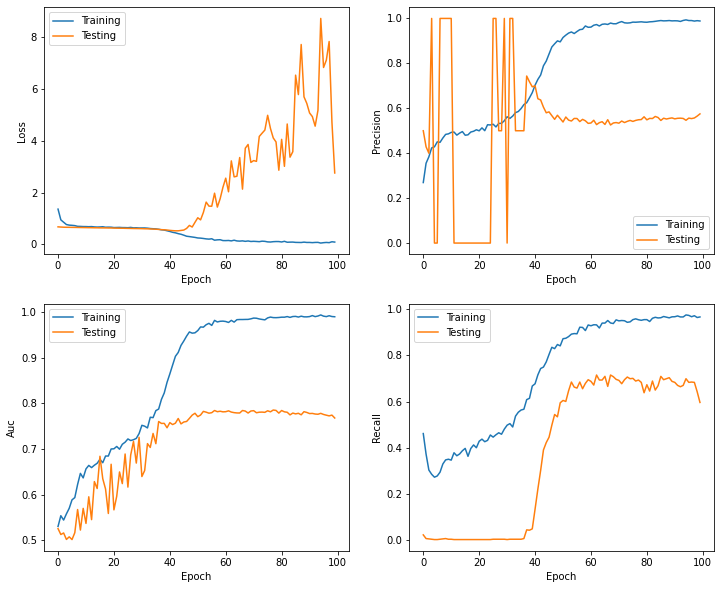

In [28]:
plot_metrics(history)

In [29]:
train_predictions_baseline = model.predict(X_train, batch_size=80)
test_predictions_baseline = model.predict(X_test, batch_size=80)

In [30]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Legitimate Transactions Detected (True Negatives):  1804
Legitimate Transactions Incorrectly Detected (False Positives):  372
Fraudulent Transactions Missed (False Negatives):  371
Fraudulent Transactions Detected (True Positives):  317
Total Fraudulent Transactions:  688


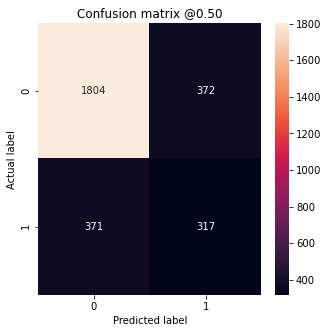

In [31]:
plot_cm(y_test, test_predictions_baseline)